# 0. Import Libraries

In [573]:
from sklearnex import patch_sklearn
patch_sklearn()
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

import numpy as np
import pandas as pd 
import scipy.stats as stats
from scipy.stats import randint, loguniform, uniform
import joblib 

import matplotlib.pyplot as plt 
import matplotlib.cm     as cm 
from matplotlib.pyplot import Axes

import seaborn as sns 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.base            import BaseEstimator, TransformerMixin

from sklearn.impute        import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder  
)
from sklearn.metrics      import (
    mean_absolute_error      as MAE,
    root_mean_squared_error  as RMSE,       
    r2_score                 as R2,
    max_error                as ME,
    PredictionErrorDisplay  
)

from sklearn import linear_model, ensemble, dummy
import catboost as cb
from typing import Dict, Union

from copy import deepcopy, copy
import os, warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore:pkg_resources is deprecated as an API:UserWarning"
plt.style.use("default")
sns.set_theme(context="notebook", style="whitegrid", palette="deep")

SEED = 42
data_path = '/home/sotsuba/student-performance/data/student_data.csv'

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# 1. Load Data

In [574]:
df = pd.read_csv(data_path)

In [575]:
df

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,3388,18,1,0,3,10.680555,2,0,4,1,0,0,0,3.455509,0.0
2388,3389,17,0,0,1,7.583217,4,1,4,0,1,0,0,3.279150,4.0
2389,3390,16,1,0,2,6.805500,20,0,2,0,0,0,1,1.142333,2.0
2390,3391,16,1,1,0,12.416653,17,0,2,0,1,1,0,1.803297,1.0


In [576]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


- It's about 10 out of 15 columns are stored as integers and floats but represent categorical variables and should be converted to categorical data type. These include:

__Ordinal category map:__ 
- `Gender`, `Ethnicity`, `ParentalEducation`, `ParentalSupport`, and `GradeClass`.

__Yes/No category map:__
- `Tutoring`, `Extracurricular`, `Sports`, `Music` and `Volunteering`.

- The GradeClass should have integer types instead of float.

## 1.1 Remap the Data

In [577]:
ordinal_cat_cols = ['ParentalEducation', 'ParentalSupport', 'GradeClass']
nominal_cat_cols = ['Ethnicity']
binary_cat_cols = ['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

#### Gender remapping

In [578]:
gender_map = {
    0: 'Female',
    1: 'Male',
}
gender_map

{0: 'Female', 1: 'Male'}

#### Ethnicity remapping

In [579]:
ethnicity_map = {
    0: 'Caucasian',
    1: 'African American',
    2: 'Asian',
    3: 'Other',
}
ethnicity_map

{0: 'Caucasian', 1: 'African American', 2: 'Asian', 3: 'Other'}

#### ParentalEducation remapping

In [580]:
parental_education_map = {
    0: 'None',
    1: 'High School',
    2: 'Some College',
    3: 'Bachelor\'s', 
    4: 'Higher', 
}
parental_education_map

{0: 'None', 1: 'High School', 2: 'Some College', 3: "Bachelor's", 4: 'Higher'}

#### ParentalSupport remapping

In [581]:
parental_support_map = {
    0: 'None',
    1: 'Low',
    2: 'Moderate',
    3: 'High', 
    4: 'Very High',
}
parental_support_map

{0: 'None', 1: 'Low', 2: 'Moderate', 3: 'High', 4: 'Very High'}

#### GradeClass remapping

In [582]:
grade_class_map = {
    0: 'A',
    1: 'B',
    2: 'C',
    3: 'D',
    4: 'F',
}
grade_class_map

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'}

#### Yes/No remapping

In [583]:
yes_no_map = {
    0: 'No',
    1: 'Yes'
}
yes_no_map

{0: 'No', 1: 'Yes'}

#### Remap the DataFrame

I just remap the data for readability

In [595]:
print('Columns that need to be remapped uniquely:')
print(ordinal_cat_cols + nominal_cat_cols, end='\n\n')

print('Columns that need to be remapped as yes/no labels:')
print(binary_cat_cols)

Columns that need to be remapped uniquely:
['ParentalEducation', 'ParentalSupport', 'GradeClass', 'Ethnicity']

Columns that need to be remapped as yes/no labels:
['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']


In [596]:
all_mappings = {
    'Gender': gender_map,
    'Ethnicity': ethnicity_map,
    'ParentalEducation': parental_education_map,
    'ParentalSupport': parental_support_map,
    'GradeClass': grade_class_map,
}

for col in binary_cat_cols:
    all_mappings[col] = yes_no_map
all_mappings['Gender'] = gender_map

all_mappings

{'Gender': {0: 'Female', 1: 'Male'},
 'Ethnicity': {0: 'Caucasian', 1: 'African American', 2: 'Asian', 3: 'Other'},
 'ParentalEducation': {0: 'None',
  1: 'High School',
  2: 'Some College',
  3: "Bachelor's",
  4: 'Higher'},
 'ParentalSupport': {0: 'None',
  1: 'Low',
  2: 'Moderate',
  3: 'High',
  4: 'Very High'},
 'GradeClass': {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'F'},
 'Tutoring': {0: 'No', 1: 'Yes'},
 'Extracurricular': {0: 'No', 1: 'Yes'},
 'Sports': {0: 'No', 1: 'Yes'},
 'Music': {0: 'No', 1: 'Yes'},
 'Volunteering': {0: 'No', 1: 'Yes'}}

In [597]:
def remap_category(df: pd.DataFrame, col: str, mapping_list: Dict[Union[int, float], str]) -> pd.Series: 
    """
    This function will do following tasks:
    - Remapping from categorical code to human-readable labels.
    - Converting data type to category.
    """
    return df[col].map(mapping_list).astype('category')

In [598]:
def remap_data(data: pd.DataFrame) -> pd.DataFrame:
    conv_df = data.copy()
    for col, mapping in all_mappings.items():
        conv_df[col] = remap_category(data, col, mapping)
    return conv_df

In [599]:
remapped_df = remap_data(df)
remapped_df['Age'] = remapped_df['Age'].astype('category')

In [600]:
remapped_df

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,Male,Caucasian,Some College,19.833723,7,Yes,Moderate,No,No,Yes,No,2.929196,C
1,1002,18,Female,Caucasian,High School,15.408756,0,No,Low,No,No,No,No,3.042915,B
2,1003,15,Female,Asian,Bachelor's,4.210570,26,No,Moderate,No,No,No,No,0.112602,F
3,1004,17,Male,Caucasian,Bachelor's,10.028829,14,No,High,Yes,No,No,No,2.054218,D
4,1005,17,Male,Caucasian,Some College,4.672495,17,Yes,High,No,No,No,No,1.288061,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2387,3388,18,Male,Caucasian,Bachelor's,10.680555,2,No,Very High,Yes,No,No,No,3.455509,A
2388,3389,17,Female,Caucasian,High School,7.583217,4,Yes,Very High,No,Yes,No,No,3.279150,F
2389,3390,16,Male,Caucasian,Some College,6.805500,20,No,Moderate,No,No,No,Yes,1.142333,C
2390,3391,16,Male,African American,None,12.416653,17,No,Moderate,No,Yes,Yes,No,1.803297,B


## 1.2. Data Dictionary

In [601]:
numerical_cols = remapped_df.select_dtypes(include='number').columns.to_list()

In [602]:
ordinal_cat_cols

['ParentalEducation', 'ParentalSupport', 'GradeClass']

In [603]:
nominal_cat_cols

['Ethnicity']

In [604]:
binary_cat_cols

['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

In [605]:
numerical_cols

['StudentID', 'StudyTimeWeekly', 'Absences', 'GPA']

| **Variable Name**   | **Role (Feature/Target)** | **Type**      | **Demographic**  | **Academic Engagement** |   **Extracurricular Engagement**   | **Description** |
|---------------------|---------------------------|---------------|------------|--|---------|-----------------|
| `Ethnicity`         | Feature                   | Nominal Category   | x | - | -           | Student’s ethnic background |
| `ParentalEducation` | Feature                   | Ordinal Category   | x | - | -    | Highest education level of the student’s parents |
| `ParentalSupport`   | Feature                   | Ordinal Category   | x | - | -                  | Type of parental support for studies |
| `GradeClass`        | Feature                | Ordinal Category   | – |  -  | -             | Final grade classification (e.g., A, B, C) |
| `Tutoring`          | Feature                   | Binary        | – |  x | -               | Whether the student receives tutoring |
| `Extracurricular`   | Feature                   | Binary        | – | - | x                  | Whether the student participates in extracurricular activities |
| `Sports`            | Feature                   | Binary        | – | - | x            | Whether the student plays sports |
| `Music`             | Feature                   | Binary        |  – | - | x            | Whether the student participates in music-related activities |
| `Volunteering`      | Feature                   | Binary        |  – | - | x                   | Whether the student does volunteering |
| `Gender`            | Feature                   | Binary        | x | - | -              | Student’s gender |
| `StudentID`         | Feature                   | Integer       | – | - | -                   | Unique identifier for each student |
| `Age`               | Feature                   | Ordinal Category | x | - | -                 | Age of the student |
| `StudyTimeWeekly`   | Feature                   | Float      | – | x | -                   | Hours spent studying weekly |
| `Absences`          | Feature                   | Integer       | –  | x | -               | Number of school absences |
| `GPA`          | Target                   | Float       | – | - | -                   | Grade Point Average |

## 1.3. Data Types

In [606]:
tar_col = 'GPA' 
num_cols = remapped_df.select_dtypes(include='number').columns.tolist()
cat_cols = remapped_df.select_dtypes(exclude='number').columns.tolist()

if 'StudentID' in num_cols:
    num_cols.remove('StudentID')
if tar_col in num_cols:
    num_cols.remove(tar_col)
if 'GradeClass' in cat_cols:
    cat_cols.remove('GradeClass')

print('Numerical Features:', num_cols)
print('Categorical Features:', cat_cols)
print('Target Features:', tar_col)

Numerical Features: ['StudyTimeWeekly', 'Absences']
Categorical Features: ['Age', 'Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']
Target Features: GPA


# 2. Exploratory Data Analysis

## 2.0. Support functions for EDA

#### 2.0.1 Statistical testing.

**Interpretation of η² benchmarks (Cohen, 1988):**
- Small: 0.01  
- Medium: 0.06  
- Large: 0.14  

In [607]:
def compute_eta_squared(data: pd.DataFrame, cat_feat: str, con_feat: str='GPA') -> None:
    grand_mean = data[con_feat].mean()
    
    ss_between = sum(len(g) * (g[con_feat].mean() - grand_mean) ** 2
                     for _, g in data.groupby(cat_feat))
    
    ss_total = ((data[con_feat] - grand_mean) ** 2).sum()
    eta2 = ss_between / ss_total if ss_total != 0 else float('nan')
    return eta2

In [608]:
def t_test(data: pd.DataFrame, cat_feat: str, con_feat: str='GPA') -> None:
    keys = data[cat_feat].unique()
    assert len(keys) == 2
    
    
    keys_1_gpa = data[data[cat_feat] == keys[0]][con_feat]
    keys_2_gpa = data[data[cat_feat] == keys[1]][con_feat]

    t_stat, p_value = stats.ttest_ind(keys_1_gpa, keys_2_gpa, equal_var=False)  
    eta2 = compute_eta_squared(data, cat_feat, con_feat)

    print(f'The Welch\'s t-test on {cat_feat}.')
    print(f'T-statistic: {t_stat:.4f}')
    print(f'P-value: {p_value:.4f}')
    print(f"Eta-squared: {eta2:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print(f'Reject the null hypothesis: significant {con_feat} difference between keys in {cat_feat} feature.')
    else:
        print(f'Fail to reject the null hypothesis: no significant {con_feat} difference between keys in {cat_feat} feature.')

In [609]:
def anova_test(data: pd.DataFrame, cat_feat: str, con_feat: str='GPA') -> None:
    groups = [data[data[cat_feat] == cat][con_feat] for cat in data[cat_feat].unique()]
    f_stat, p_value = stats.f_oneway(*groups)
    eta2 = compute_eta_squared(data, cat_feat, con_feat)
    print(f'The ANOVA test.')
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Eta-squared: {eta2:.4f}")

    if p_value < 0.05:
        print(f'Significant difference in {con_feat} across {cat_feat}.')
        # res = stats.tukey_hsd(*groups)
        # print(res)
    else:
        print(f'No significant difference in {con_feat} across {cat_feat}.')

### 2.0.2 Visualization

In [610]:
def plot_series(kind: str, series: pd.Series, col: str, ax: Union[Axes, None]=None, **kwargs) -> None:
    series.plot(kind=kind, title=f'{col} Distribution', ax=ax, **kwargs)
    if kind is not 'pie':
        for i, (index, value) in enumerate(series.items()):
            ax.text(value - max(series) * 0.08, i, f'{value}', va='center')
            ax.set_xlabel('Count')
    else:
        ax.legend(title=col)

In [611]:
def plot_gpa(colors, ax: Axes) -> None:
    """
    This function plots the GPA distribution with some unique colors equivalent to the GradeClass.
    """
    grade_bins = [0, 2.0, 2.5 , 3.0, 3.5, 4.0]
    grade_labels = ['F', 'D', 'C', 'B', 'A']
    temp_grade = pd.cut(
        remapped_df['GPA'],
        bins=grade_bins,
        labels=grade_labels,
        include_lowest=True,
        right=True
    )

    # Grade order and colors (matches your original palette)
    grade_order = ['A', 'B', 'C', 'D', 'F']
    colors = dict(zip(grade_order, colors))

    sns.histplot(
        x=remapped_df['GPA'],
        hue=temp_grade,
        hue_order=grade_order,
        palette=colors,
        bins=8,
        multiple='stack',
        ax=ax
    )
    ax.set_title('Gpa histogram')
    ax.get_legend().remove()

In [612]:
def plot_bar_and_pie(data: pd.DataFrame, selected_col: str, cmap_name: str='Pastel1', size: int=2) -> None:
    tar_series = data[selected_col].value_counts().sort_values()
    n = len(tar_series)
    
    colors = cm.get_cmap(cmap_name, n)(np.arange(n))
    common_kwargs = {
        'col': selected_col,
        'series': tar_series,
    }
    
    fig, axs = plt.subplots(1, size, figsize=(size * 8, 6))
    axs = axs.flatten()

    plot_series(kind='pie', ax=axs[0], autopct='%.2f%%', colormap=cmap_name, **common_kwargs)
    plot_series(kind='barh', ax=axs[1], color=colors, **common_kwargs)
    
    if size == 3: 
        plot_gpa(colors, axs[2])
    plt.tight_layout()
    plt.show()
    print('\n-------------------------')
    print(f'{selected_col} Count',end='\n-------------------------\n')
    print(tar_series)
    if size == 2:
        print('\n\n\n-------------------------')
        print(f'{selected_col} Impact on GPA',end='\n-------------------------\n')
        print(data.groupby(selected_col)['GPA'].mean().sort_values())
    

### 2.0.3. Support function for Univariate/Bivariate Analysis.

#### Category Analysis

In [613]:
def univariate_experiment_category(data, selected_feat, palette="Set3", title=None, ax=None, order=None):
    # Ensure correct order if provided
    if order is not None:
        data[selected_feat] = pd.Categorical(data[selected_feat], categories=order, ordered=True)
        vc = data[selected_feat].value_counts().reindex(order)
    else:
        vc = data[selected_feat].value_counts()
    
    pct = (vc / len(data) * 100).round(2)
    order_list = vc.index.tolist()

    colors = cm.get_cmap(palette, len(order_list))(np.arange(len(order_list)))
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    bars = ax.barh(order_list, vc.values, color=colors, edgecolor="none")

    for bar, p in zip(bars, pct.values):
        x = bar.get_width()
        y = bar.get_y() + bar.get_height()/2
        ax.text(x + 0.02 * vc.max(), y, f"{int(x)}  ({p:.2f}%)",
                va="center", ha="left", fontsize=11, clip_on=True)

    ax.set_title(title or f"{selected_feat} Distribution")
    ax.set_xlabel("Count")
    ax.set_ylabel(selected_feat)
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.set_xlim(0, vc.max() * 1.25)
    return ax

In [614]:
def cat_con_experiment(data: pd.DataFrame, cat_feat: str, con_feat: str='GPA', ax: Axes=None, order=None, title: str=None) -> None:
    if order is not None:
        data[cat_feat] = pd.Categorical(data[cat_feat], categories=order, ordered=True)
    if con_feat == 'GPA':
        ax = sns.boxplot(data=data, x=cat_feat, y=con_feat, ax=ax, order=order)
        ax.set_title(title or f'{cat_feat} vs {con_feat}')

    n = len(data[cat_feat].unique()) 
    if n == 2:
        t_test(data, cat_feat, con_feat)
    elif n > 2:
        anova_test(data, cat_feat, con_feat)
        
    print(f'\{con_feat} vs {cat_feat} mean')
    print(data.groupby(cat_feat)[con_feat].mean().sort_values(ascending=False))
    print(f'\{con_feat} vs {cat_feat} median')
    print(data.groupby(cat_feat)[con_feat].median().sort_values(ascending=False))

#### Numerical Analysis

In [615]:
def numerical_data_experiment(data: pd.DataFrame, selected_feat: str, bins: int, ax: Axes=None) -> None:
    plt.figure(figsize=(16,6))
    ax = sns.histplot(data, x=selected_feat, kde=True, bins=bins)
    plt.tight_layout()
    plt.show()
    
    f, axs = plt.subplots(1, 3,figsize=(16, 6))
    axs = axs.flatten()

    sns.boxplot(data, x=selected_feat, y='GradeClass', ax=axs[0])
    sns.histplot(data, x=selected_feat, hue='GradeClass',  kde=True, ax=axs[1], bins=bins)
    sns.kdeplot(data, x=selected_feat, hue='GradeClass', multiple='fill', ax=axs[2])
    plt.tight_layout()
    for i in range(3):
        axs[i].set_xbound([data[selected_feat].min(), data[selected_feat].max()])
    plt.show()
    print(data.groupby('GradeClass')[selected_feat].describe())

In [616]:
def plot_stuff(data: pd.DataFrame, selected_feat: str, order=None) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    univariate_experiment_category(data, selected_feat, ax=axs[0], order=order)
    cat_con_experiment(data, selected_feat, ax=axs[1], order=order)
    plt.tight_layout()
    plt.show()

### 2.0.4 Support function for Multivariate Analysis.


In [617]:
def binary_multivariate_experiment(data: pd.DataFrame, bin_feat: str, cat_feat: str, order=None, con_feat: str='GPA'):
    if order is not None:
        data[cat_feat] = pd.Categorical(data[cat_feat], categories=order, ordered=True)
    sns.boxplot(remapped_df, x=cat_feat, y=con_feat, hue=bin_feat, order=order)
    plt.legend(title=bin_feat, loc="center")  
    plt.tight_layout()
    plt.show()

    
    results = []
    for cat in order:
        sub = data[(data[cat_feat] == cat)]
        group_yes = sub[sub[bin_feat] == 'Yes'][con_feat]
        group_no  = sub[sub[bin_feat] == 'No'][con_feat]
        
        t_stat, p_val = stats.ttest_ind(group_yes, group_no, equal_var=False)  
        eta2 = compute_eta_squared(sub, cat_feat=bin_feat, con_feat=con_feat)
        
        results.append({
            'ParentalSupport': cat,
            'count_Yes': len(group_yes),
            'mean_GPA_Yes': group_yes.mean(),
            'count_No': len(group_no),
            'mean_GPA_No': group_no.mean(),
            'delta_mean': group_yes.mean() - group_no.mean(),
            't_stat': t_stat,
            'p_value': p_val,
            'reject_null_hypothesis': p_val < 0.05,
            'eta_squared': eta2
        })

    print(pd.DataFrame(results))    

## 2.1. Overview Data

In [618]:
remapped_df.describe()

,StudentID,StudyTimeWeekly,Absences,GPA
count,2392.000000,2392.000000,2392.000000,2392.000000
mean,2196.500000,9.771992,14.541388,1.906186
std,690.655244,5.652774,8.467417,0.915156
min,1001.000000,0.001057,0.000000,0.000000
25%,1598.750000,5.043079,7.000000,1.174803
50%,2196.500000,9.705363,15.000000,1.893393
75%,2794.250000,14.408410,22.000000,2.622216
max,3392.000000,19.978094,29.000000,4.000000


In [619]:
cat_df_info = []
for cat in cat_cols:
    cat_df_info.append({
        'column': cat,
        'unique_values': remapped_df[cat].nunique(),
        'sample_values': list(remapped_df[cat].dropna().unique())
    })

cat_df_info = pd.DataFrame(cat_df_info)
cat_df_info

,column,unique_values,sample_values
0,Age,4,"[17, 18, 15, 16]"
1,Gender,2,"[Male, Female]"
2,Ethnicity,4,"[Caucasian, Asian, African American, Other]"
3,ParentalEducation,5,"[Some College, High School, Bachelor's, Higher..."
4,Tutoring,2,"[Yes, No]"
5,ParentalSupport,5,"[Moderate, Low, High, Very High, None]"
6,Extracurricular,2,"[No, Yes]"
7,Sports,2,"[No, Yes]"
8,Music,2,"[Yes, No]"
9,Volunteering,2,"[No, Yes]"


## 2.2. Data Quality Check

#### 2.2.1. Check mislabeled data

`GradeClass`: Classification of students' grades based on `GPA`:


| GradeClass Code | Grade Label | Range       |
|-----------------|-------------|--------------------|
| **0**           | A           | GPA ≥ 3.5          | 
| **1**           | B           | 3.0 ≤ GPA < 3.5    |
| **2**           | C           | 2.5 ≤ GPA < 3.0    |
| **3**           | D           | 2.0 ≤ GPA < 2.5    | 
| **4**           | F           | GPA < 2.0          |

In [621]:
def gpa_to_grade(gpa: float) -> int:
    if gpa >= 3.5:
        return 0
    elif gpa >= 3.0:
        return 1
    elif gpa >= 2.5:
        return 2
    elif gpa >= 2.0:
        return 3
    return 4

def check_mislabel(data: pd.DataFrame) -> None:
    df = data.copy()

    df["GradeClass"] = pd.to_numeric(df["GradeClass"], errors="coerce").astype("Int64")

    df["ManualGradeClass"] = df["GPA"].apply(gpa_to_grade)
    df["Mislabeled"] = df["ManualGradeClass"] != df["GradeClass"]

    n = len(df)
    miss = int(df["Mislabeled"].sum())
    print(f"The number of rows mislabeled: {miss}/{n} ({miss/n:.2%})")

    print("\nPer-class totals and rates:")
    per_class = df.groupby("GradeClass")["Mislabeled"].agg(count="sum", total="size", rate="mean")
    print(per_class.assign(rate=(per_class["rate"]*100).round(2)).rename(columns={"rate":"rate_%"}))
    if miss > 0:
        print('\nThere are SOME mislabeled data.')
        print(df[(df['GradeClass'] == 0) & (df['Mislabeled'] == True)].head(5))
    else:
        print('\nThere are NO mislabeled data.')


In [622]:
check_mislabel(df)

The number of rows mislabeled: 168/2392 (7.02%)

Per-class totals and rates:
            count  total  rate_%
GradeClass                      
0              36    107   33.64
1              40    269   14.87
2              31    391    7.93
3              39    414    9.42
4              22   1211    1.82

There are SOME mislabeled data.
      StudentID  Age  Gender  Ethnicity  ParentalEducation  StudyTimeWeekly  \
2194       3195   15       0          0                  2        15.615710   
2198       3199   16       1          1                  3         1.511090   
2211       3212   17       1          0                  2         5.319481   
2214       3215   16       0          2                  1        18.982249   
2220       3221   18       0          0                  1         0.185050   

      Absences  Tutoring  ParentalSupport  Extracurricular  Sports  Music  \
2194        26         0                3                1       0      0   
2198         3         0      

- In **Grade A** (`GradeClass = 0`), **36 rows** are mislabeled.
- Some cases are **severe mislabels**, such as GPA = **0.57** but labeled as `GradeClass = 'A'`.

In [623]:
df['GradeClass'] = df['GPA'].apply(gpa_to_grade)

In [624]:
check_mislabel(df)

The number of rows mislabeled: 0/2392 (0.00%)

Per-class totals and rates:
            count  total  rate_%
GradeClass                      
0               0     77     0.0
1               0    244     0.0
2               0    385     0.0
3               0    412     0.0
4               0   1274     0.0

There are NO mislabeled data.


### 2.2.2. Check invalid schemas

In [625]:
checks = {
    "GPA": lambda s: s.between(0.0, 4.0),
    "StudyTimeWeekly": lambda s: s.between(0, 20),
    "Absences": lambda s: s.between(0, 30),
    "Tutoring": lambda s: s.isin([0,1]),
    "Extracurricular": lambda s: s.isin([0,1]),
    "Sports": lambda s: s.isin([0,1]),
    "Music": lambda s: s.isin([0,1]),
    "Volunteering": lambda s: s.isin([0,1]),
}

In [626]:
violations = {c: int((~rule(df[c])).sum()) for c, rule in checks.items() if c in df}

if sum(list(violations.values())) == 0:
    print('There are NO invalid schemas.')
else:
    print('There are SOME invalid schemas.')    
    pd.Series(violations)[lambda x: x>0]

There are NO invalid schemas.


### 2.2.3. Check duplicated/missing/outlier data and data types

In [627]:
print(df.isnull().sum())
print(f'Number of missing data: {df.isnull().sum().sum()}')

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64
Number of missing data: 0


In [628]:
print(f'Number of duplicated data: {df.duplicated().sum()}')

Number of duplicated data: 0


In [629]:
df.describe()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,2196.500000,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,3.071070
std,690.655244,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.177639
min,1001.000000,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1598.750000,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,2196.500000,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,2794.250000,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,3392.000000,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [630]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 280.4 KB


Some of category features might be misunderstanding when doing EDA edue to their wrong data types. Remapping to the string-based labels should be considered to gain readability. 

In [631]:
remapped_df = remap_data(df)

In [632]:
remapped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   StudentID          2392 non-null   int64   
 1   Age                2392 non-null   int64   
 2   Gender             2392 non-null   category
 3   Ethnicity          2392 non-null   category
 4   ParentalEducation  2392 non-null   category
 5   StudyTimeWeekly    2392 non-null   float64 
 6   Absences           2392 non-null   int64   
 7   Tutoring           2392 non-null   category
 8   ParentalSupport    2392 non-null   category
 9   Extracurricular    2392 non-null   category
 10  Sports             2392 non-null   category
 11  Music              2392 non-null   category
 12  Volunteering       2392 non-null   category
 13  GPA                2392 non-null   float64 
 14  GradeClass         2392 non-null   category
dtypes: category(10), float64(2), int64(3)
memory usage: 118

In [633]:
id_col = 'StudentID'
num_cols = remapped_df.select_dtypes(include='number').columns.drop(id_col)
cat_cols = remapped_df.select_dtypes(exclude='number').columns

In [634]:
remapped_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2392.0,16.468645,1.123798,15.000000,15.000000,16.000000,17.000000,18.000000
StudyTimeWeekly,2392.0,9.771992,5.652774,0.001057,5.043079,9.705363,14.408410,19.978094
Absences,2392.0,14.541388,8.467417,0.000000,7.000000,15.000000,22.000000,29.000000
GPA,2392.0,1.906186,0.915156,0.000000,1.174803,1.893393,2.622216,4.000000


In [635]:
cat_stats = []
for c in cat_cols:
    cat_stats.append([
        c, 
        remapped_df[c].dtype, 
        remapped_df[c].nunique(),
        remapped_df[c].value_counts().to_dict()
    ])
cat_stats = pd.DataFrame(cat_stats, columns=['Cat-col', 'dtype', 'num_unique_value', 'value_counts'])

cat_stats.style.set_table_attributes('style="display:inline"') \
    .set_properties(**{'text-align': 'left'}) \
    .hide(axis='index')


Cat-col,dtype,num_unique_value,value_counts
Gender,category,2,"{'Male': 1222, 'Female': 1170}"
Ethnicity,category,4,"{'Caucasian': 1207, 'African American': 493, 'Asian': 470, 'Other': 222}"
ParentalEducation,category,5,"{'Some College': 934, 'High School': 728, ""Bachelor's"": 367, 'None': 243, 'Higher': 120}"
Tutoring,category,2,"{'No': 1671, 'Yes': 721}"
ParentalSupport,category,5,"{'Moderate': 740, 'High': 697, 'Low': 489, 'Very High': 254, 'None': 212}"
Extracurricular,category,2,"{'No': 1475, 'Yes': 917}"
Sports,category,2,"{'No': 1666, 'Yes': 726}"
Music,category,2,"{'No': 1921, 'Yes': 471}"
Volunteering,category,2,"{'No': 2016, 'Yes': 376}"
GradeClass,category,5,"{'F': 1274, 'D': 412, 'C': 385, 'B': 244, 'A': 77}"


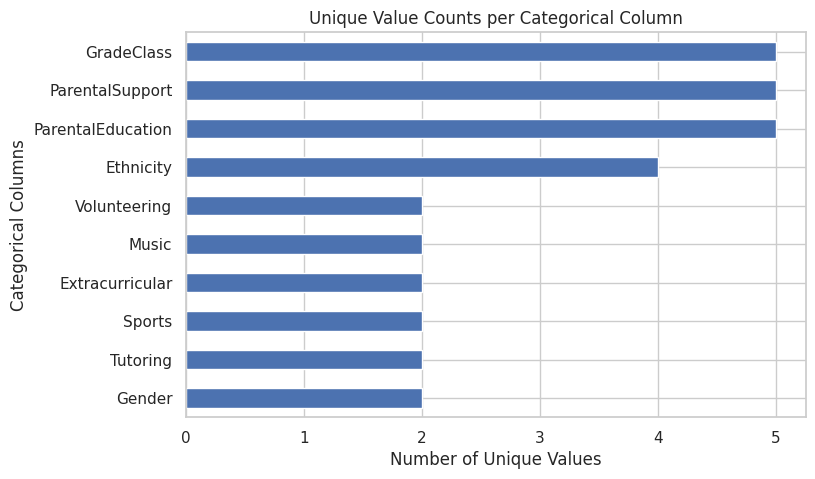

In [636]:
import matplotlib.pyplot as plt

cat_unique_counts = remapped_df[cat_cols].nunique().sort_values()
plt.figure(figsize=(8, 5))
cat_unique_counts.plot(kind='barh')
plt.xlabel("Number of Unique Values")
plt.ylabel("Categorical Columns")
plt.title("Unique Value Counts per Categorical Column")
plt.show()


## 2.3. Target Analysis

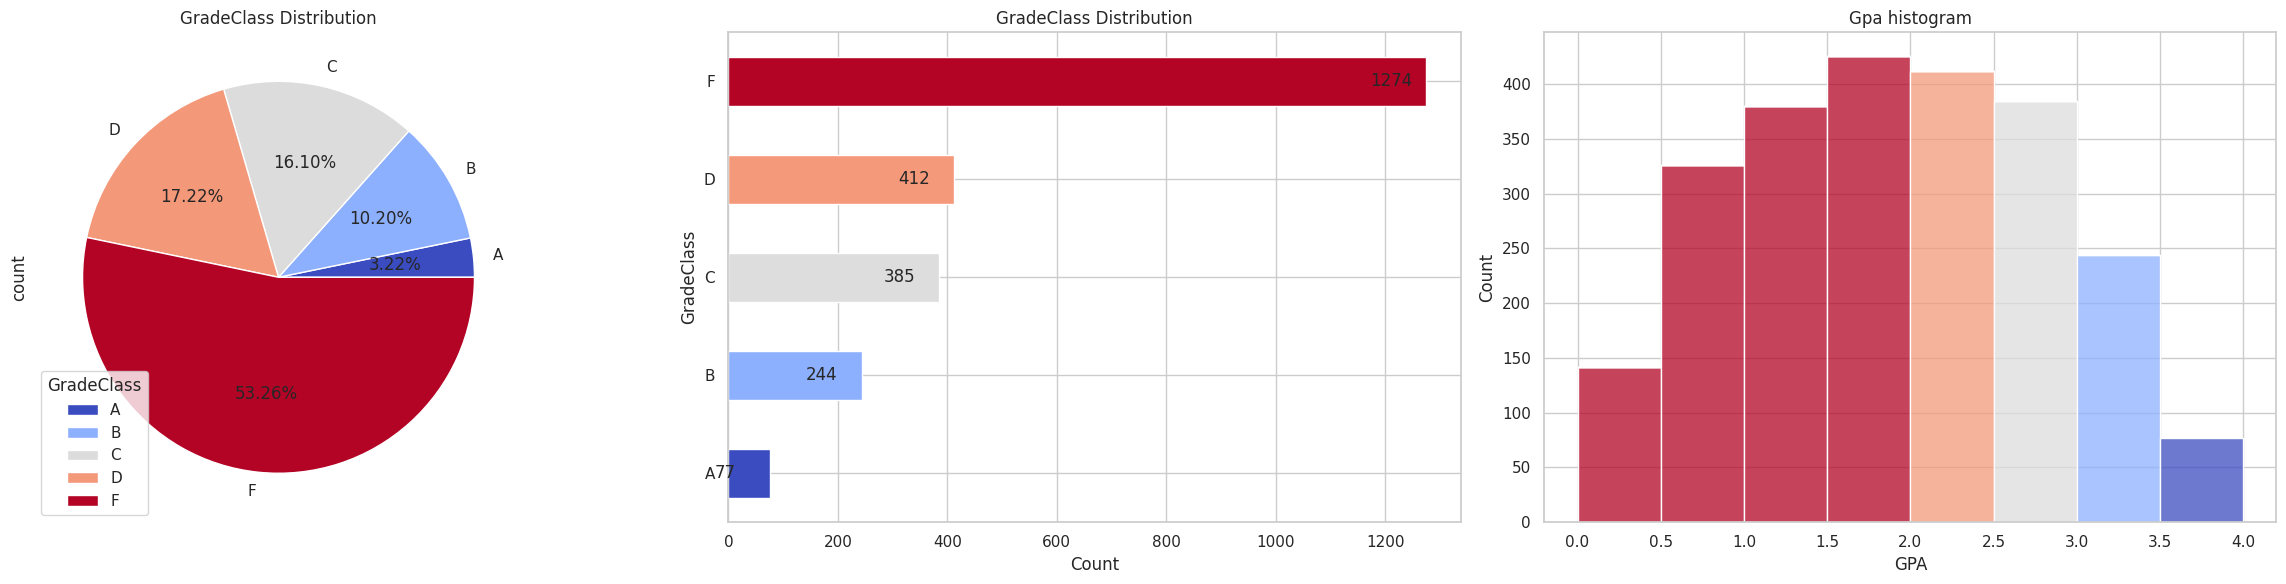


-------------------------
GradeClass Count
-------------------------
GradeClass
A      77
B     244
C     385
D     412
F    1274
Name: count, dtype: int64


In [637]:
# Let's assume that the target column is temp_tar_col.
temp_tar_col = 'GradeClass'
plot_bar_and_pie(remapped_df, temp_tar_col, 'coolwarm', 3)

__Observation:__
- The `GPA` column has a **bell-shaped distribution**, indicating a natural spread of student performance without strong skew toward either extreme.  
- The `GradeClass` column is **highly imbalanced** — over **50%** of students are in grade **'F'**, while only about **5%** are in grade **'A'**.  
- This imbalance results from **strict grade thresholds**, which segment the GPA distribution in a way that creates a sharp divide between top- and low-performing students.


__Conclusion:__
- The problem will be approached as a regression task, with `GPA` as the predictive feature, due to its continuous nature and favorable bell-shaped distribution. Predicted GPA values can later be converted to `GradeClass` for reporting (target feature).

Now let's take a look at our predictive feature: `GPA`.

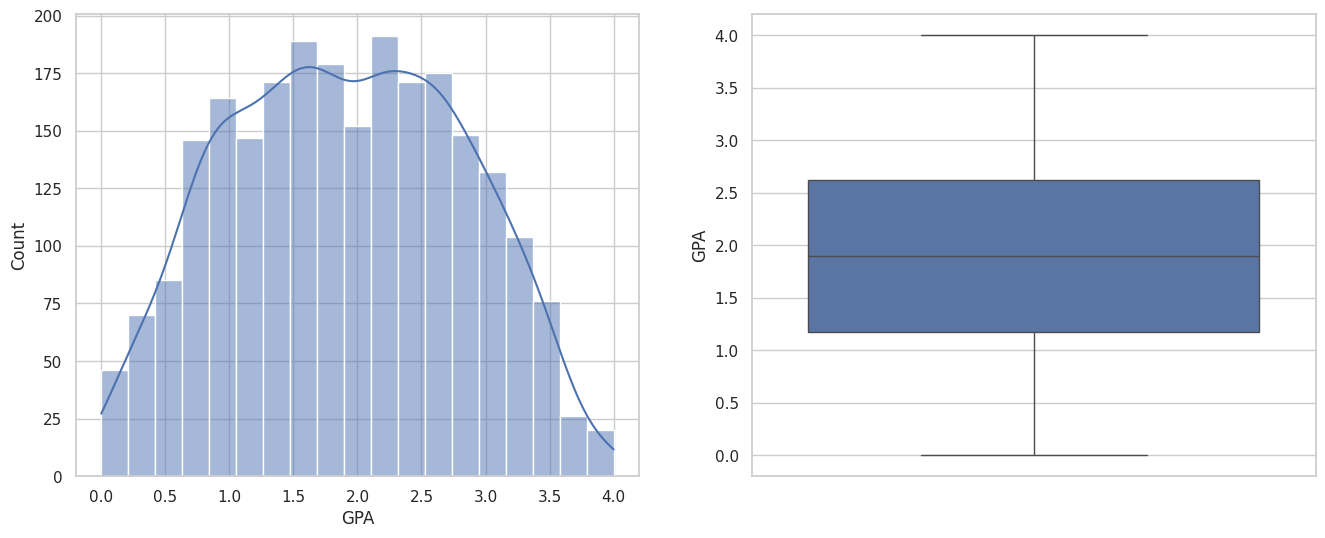

In [638]:
tar_col = 'GPA'

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(remapped_df[tar_col],ax=axs[0], kde=True)
sns.boxplot(remapped_df[tar_col], ax=axs[1])
plt.show()

The target features has bell-like distribution but with a slighly loose in [1.8, 2.2].

## 2.4. Demographic Analysis

**Interpretation of η² benchmarks (Cohen, 1988) for reference:**
- Small: 0.01  
- Medium: 0.06  
- Large: 0.14  

### 2.4.1. `Gender` Feature

##### Visualization

The Welch's t-test on Gender.
T-statistic: -0.6532
P-value: 0.5137
Eta-squared: 0.0002
Fail to reject the null hypothesis: no significant GPA difference between keys in Gender feature.
\GPA vs Gender mean
Gender
Female    1.918679
Male      1.894225
Name: GPA, dtype: float64
\GPA vs Gender median
Gender
Female    1.920006
Male      1.876211
Name: GPA, dtype: float64


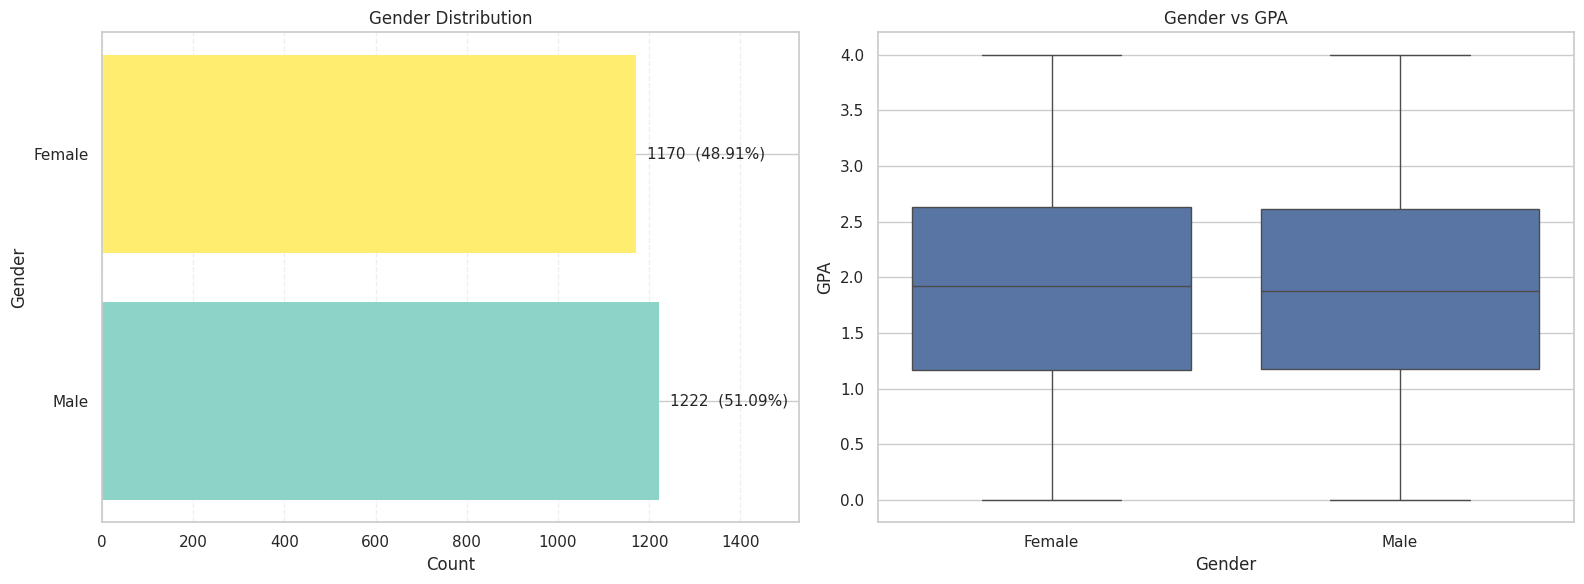

In [639]:
plot_stuff(remapped_df, 'Gender')

#### Observation

- This shows that the sample is almost balanced in Gender, with ~49% Female and ~51% Male.
- Boxplots showed no extreme outliers, Female group have higher median (1.92) to the Male (1.87).
- The female group has a slightly higher mean GPA (1.91) compared to the male group (1.89), a difference of only 0.02 GPA points. 
- Welch’s t-test (T ≈ -0.65, p ≈ 0.51) fails to reject the null hypothesis. Eta-squared ~0.0002 suggesting the tiny explanation of GPA variance by Gender.


#### Implication

- This feature has a very small correlation to GPA (explains 0.02% GPA variance)
- This feature can be deprioritized for the first model training. 

### 2.4.2. `Age` Feature

#### Visualization

The ANOVA test.
F-statistic: 0.1625
P-value: 0.9216
Eta-squared: 0.0002
No significant difference in GPA across Age.
\GPA vs Age mean
Age
17    1.927030
16    1.907534
15    1.898509
18    1.892101
Name: GPA, dtype: float64
\GPA vs Age median
Age
17    1.992299
15    1.893825
16    1.885850
18    1.795152
Name: GPA, dtype: float64


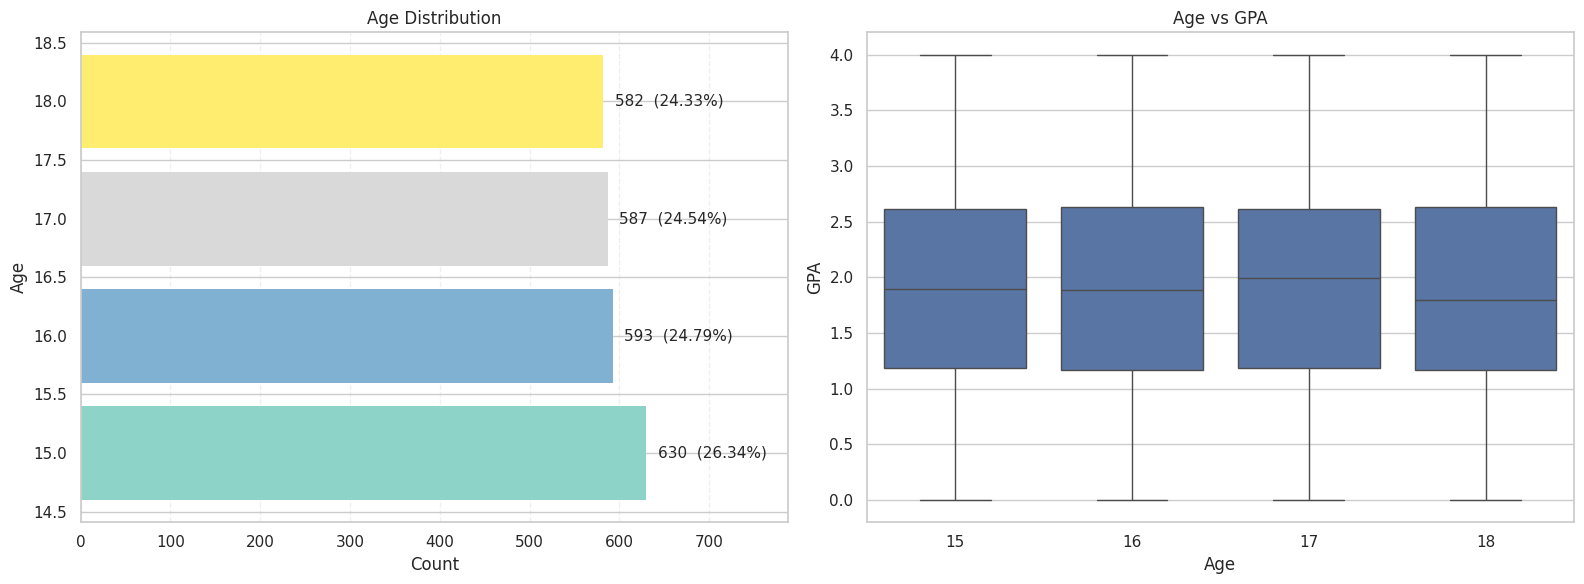

In [640]:
plot_stuff(remapped_df, 'Age')

#### Observation

- Age distribution is balanced across the four categories (15–18 years old), with each group representing roughly 24–26% of the dataset.
- 17 year-old students have the best average GPA when compares to the other. (1.93), follows up by 16 (1.91), 15 (1.90), 14(1.89).
- Boxplots showed no extreme outliers, 17 year-old students have the highest median (1.99), the 18 year-old students have the smallest median (1.79) 
- ANOVA (F ≈ 0.16, p ≈ 0.92) fails to reject the null hypothesis. Statistically, GPA is almost the same across those groups. 
- Eta-squared (0.0002) indicating Age explains 0.02% of the GPA variance.

#### Implication

- Just like `Gender` feature.

### 2.4.3. `Ethnicity` Feature

#### Visualization

The ANOVA test.
F-statistic: 0.9581
P-value: 0.4116
Eta-squared: 0.0012
No significant difference in GPA across Ethnicity.
\GPA vs Ethnicity mean
Ethnicity
Other               1.947696
African American    1.946437
Asian               1.922125
Caucasian           1.875905
Name: GPA, dtype: float64
\GPA vs Ethnicity median
Ethnicity
Other               1.997668
African American    1.948328
Asian               1.879306
Caucasian           1.843597
Name: GPA, dtype: float64


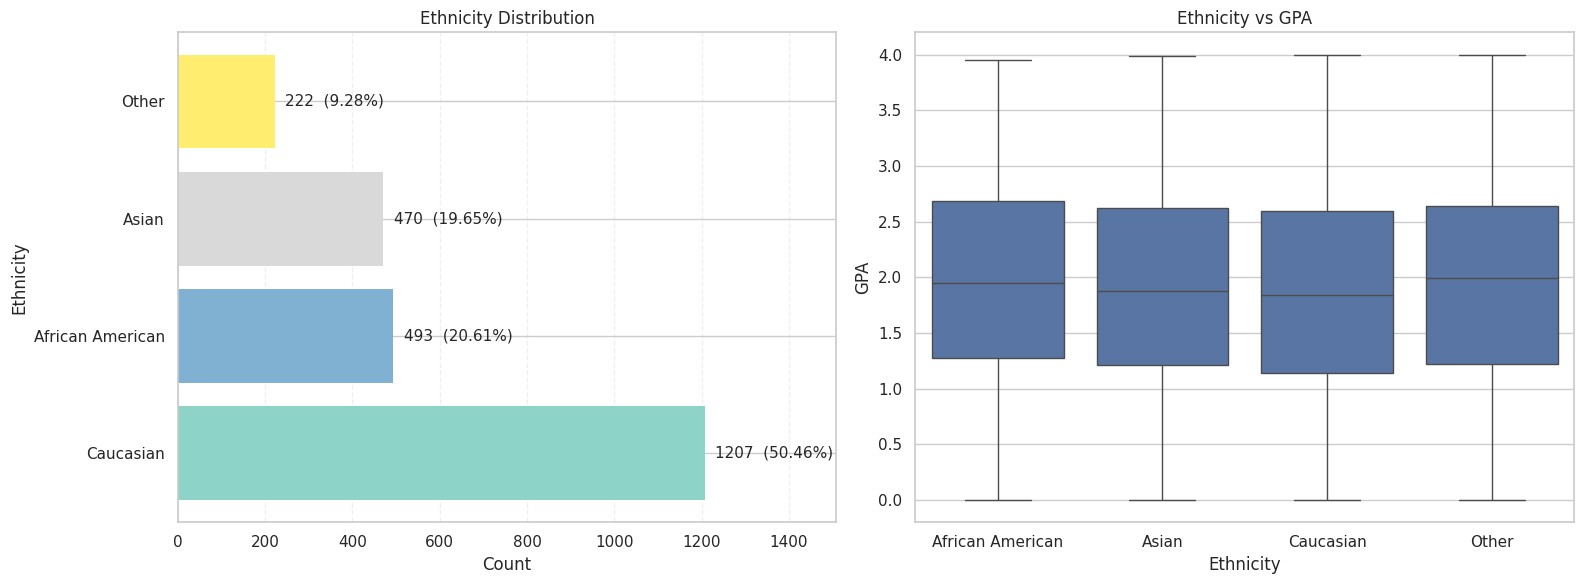

In [641]:
plot_stuff(remapped_df, 'Ethnicity')

#### Observation

- Caucasian' comprising 50.46%, of the dataset while 'Other' comprises only 9.28%.
- Mean GPA ranges from 1.875 (Caucasian) to 1.948 (Other). Univariate ANOVA (F = ~0.96, P = ~0.41) fails to reject null hypothesis. 
- The eta-squared (0.0012) suggests that Ethnicity explains only 0.12% of GPA variance.

#### Implication

- This feature has a very small correlation to GPA (explains 0.12% GPA variance)
- This feature can be deprioritized for the first model training. 

### 2.4.4. `ParentalEducation` Feature

#### Visualization

The ANOVA test.
F-statistic: 1.8081
P-value: 0.1245
Eta-squared: 0.0030
No significant difference in GPA across ParentalEducation.
\GPA vs ParentalEducation mean
ParentalEducation
High School     1.944022
Some College    1.929881
None            1.893045
Higher          1.815812
Bachelor's      1.809082
Name: GPA, dtype: float64
\GPA vs ParentalEducation median
ParentalEducation
High School     1.954103
Some College    1.891948
Bachelor's      1.855866
None            1.855667
Higher          1.711729
Name: GPA, dtype: float64


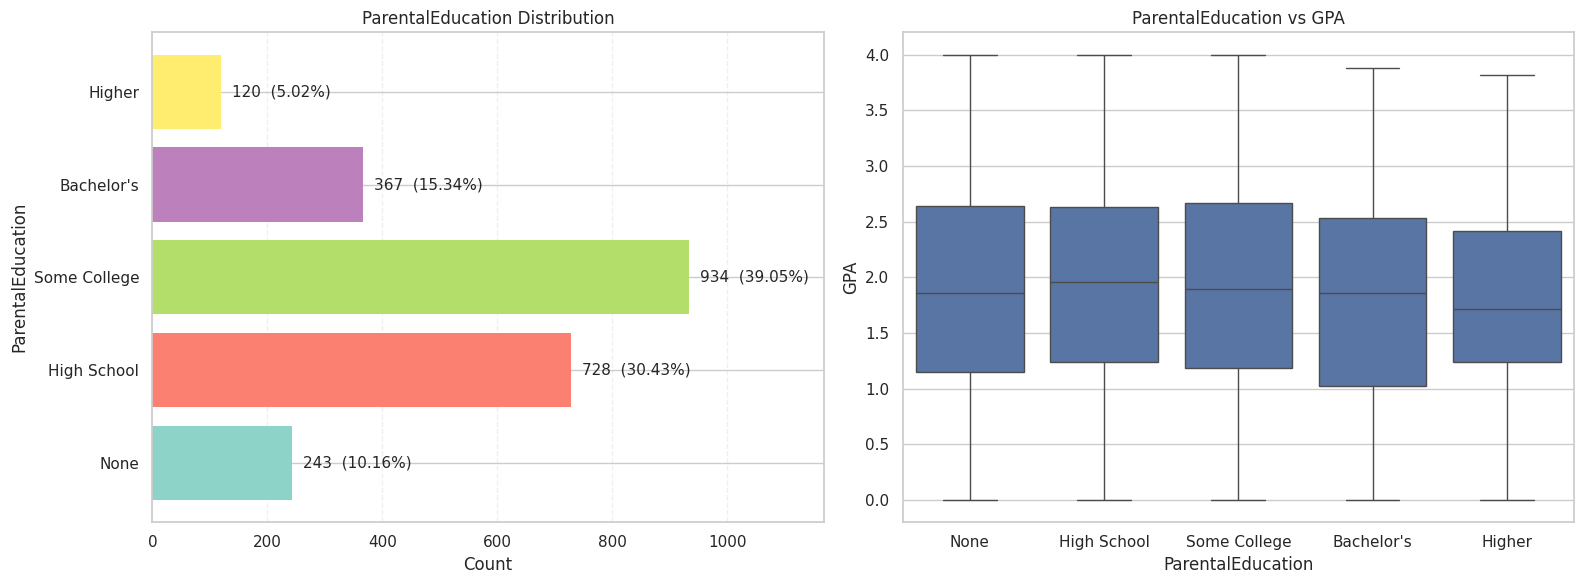

In [642]:
parental_education_order = list(parental_education_map.values())
plot_stuff(remapped_df, 'ParentalEducation', order=parental_education_order)

#### Observation

- The `Ethnicity` feature is imbalanced, with 'Caucasian' comprising 50.46% of the dataset while 'Other' comprises only 9.28%.
- Mean GPA ranges from 1.875 (Caucasian) to 1.948 (Other). Univariate ANOVA (F = ~0.96, P = ~0.41) fails to reject null hypothesis. 
- The eta-squared (~0.12%) suggests that Ethnicity explains only 0.12% of GPA variance.

#### Implication

- This feature has a very small correlation to GPA (explains 0.3% GPA variance)
- This feature can be deprioritized for the first model training. 

### 2.4.5. `ParentalSupport` Feature

The ANOVA test.
F-statistic: 22.7235
P-value: 0.0000
Eta-squared: 0.0367
Significant difference in GPA across ParentalSupport.
\GPA vs ParentalSupport mean
ParentalSupport
Very High    2.191545
High         2.042409
Moderate     1.884246
Low          1.755700
None         1.540128
Name: GPA, dtype: float64
\GPA vs ParentalSupport median
ParentalSupport
Very High    2.197582
High         2.048850
Moderate     1.879412
Low          1.757092
None         1.405750
Name: GPA, dtype: float64


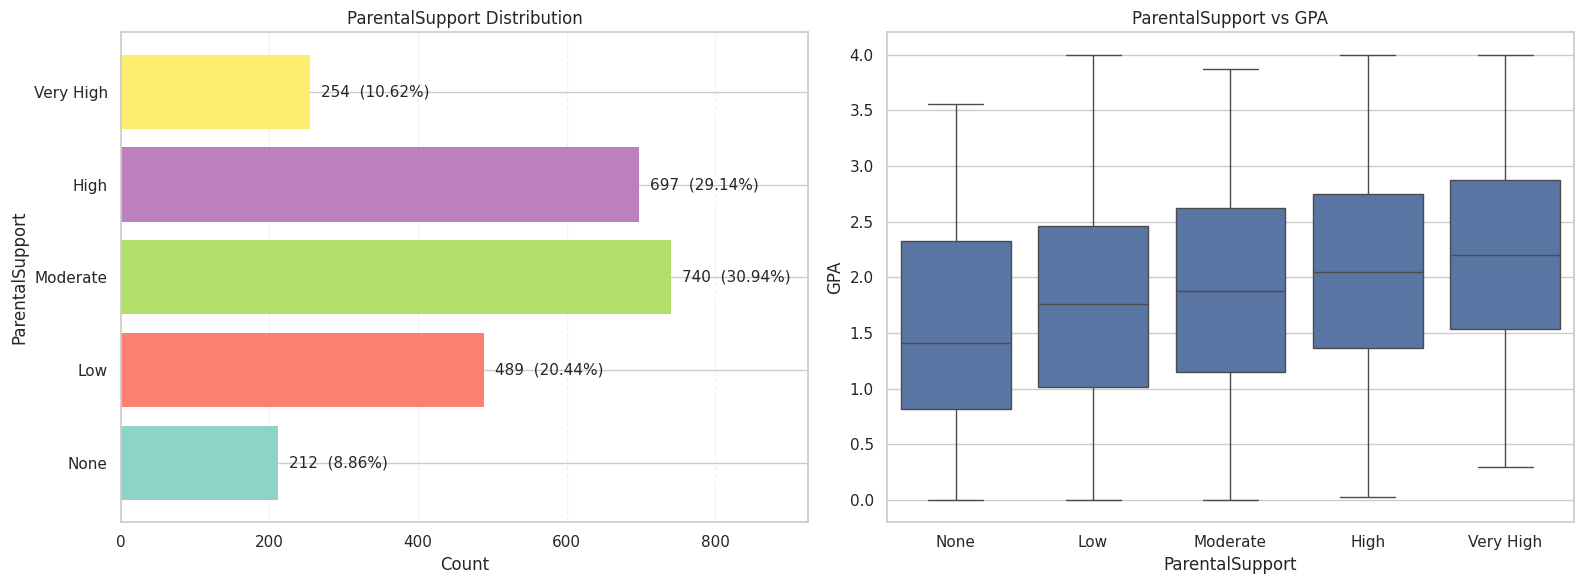

In [477]:
parental_support_order = list(parental_support_map.values())
plot_stuff(remapped_df, 'ParentalSupport', order=parental_support_order)

#### Observation

- `None` has the smallest portion (8.86%), ParentalSupport is mostly at Moderate/High level (almost 60%).
- There is a clear positive relationship between `GPA` and `ParentalSupport`. Higher ParentalSupport correspond to higher mean and median values.
- Boxplots showed no extreme outliers, 17 year-old students have the highest median (1.99), the 18 year-old students have the smallest median (1.79) 
- ANOVA (F ≈ 22.7235, p ≈ 0.0000) rejects the null hypothesis, which strongly suggests that at least 1 couple in `ParentalSupport` are differ in mean. Therefore, this feature has predictive potential. (I decide not to use post-hoc  test for checking which 'couple' differs in mean simply because I don't understand it at all).
- Eta-squared (0.0367) indicating `ParentalSupport` explains 3.67% of the GPA variance, which is a moderate effect.

#### Implication

- This feature has a moderate correlation to GPA (explains 3.67% GPA variance)
- This is a potential feature for prediction and should be kept for training, searching the relationship with other features.

### 2.4.6. Overall

- Most of features in Demographic group are not corespond to GPA, expect the `ParentalSupport` (3.67% GPA variance explained). Therefore, `ParentalSuppport` is worth to work on.
- That high school can call for parent involvement whenever they find out a students that likely perform worse.

## 2.5. Academic Engangement Analysis

### 2.5.1. `Tutoring` Feature

#### Visualization

The Welch's t-test on Tutoring.
T-statistic: 7.1725
P-value: 0.0000
Eta-squared: 0.0211
Reject the null hypothesis: significant GPA difference between keys in Tutoring feature.
\GPA vs Tutoring mean
Tutoring
Yes    2.108325
No     1.818968
Name: GPA, dtype: float64
\GPA vs Tutoring median
Tutoring
Yes    2.095691
No     1.818613
Name: GPA, dtype: float64


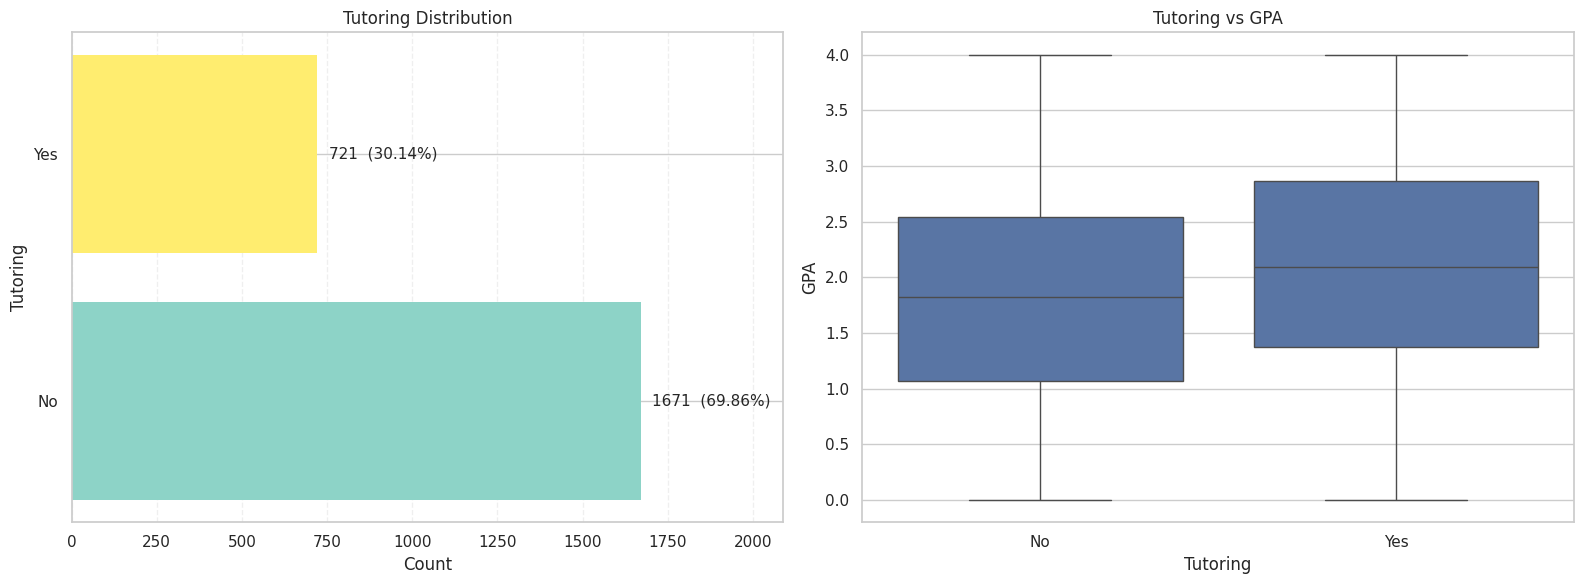

In [478]:
plot_stuff(remapped_df, 'Tutoring')

#### Observation

- Majority of students (69,86%) not participate in Tutoring. On other side, Students who participate in Tutoring account for a smaller portion (30.14%), but this is still a substantial proportion of the dataset.
- Students who receive Tutoring have a higher average GPA (+0.29 points) compared to those without Tutoring.
- Welch's t-test (T = ~7,17, p = ~0) rejects the null hypothesis.
- The Eta-squared with ~2.1% suggests that `Tutoring` feature explains ~2.1% GPA variance.

#### Implication

- This feature has a moderate correlation to GPA (explains 2.1% GPA variance)
- This is a potential feature for prediction and should be kept for training, searching the relationship with other features.

### 2.5.2. `StudyTimeWeekly` Feature

#### Visualization

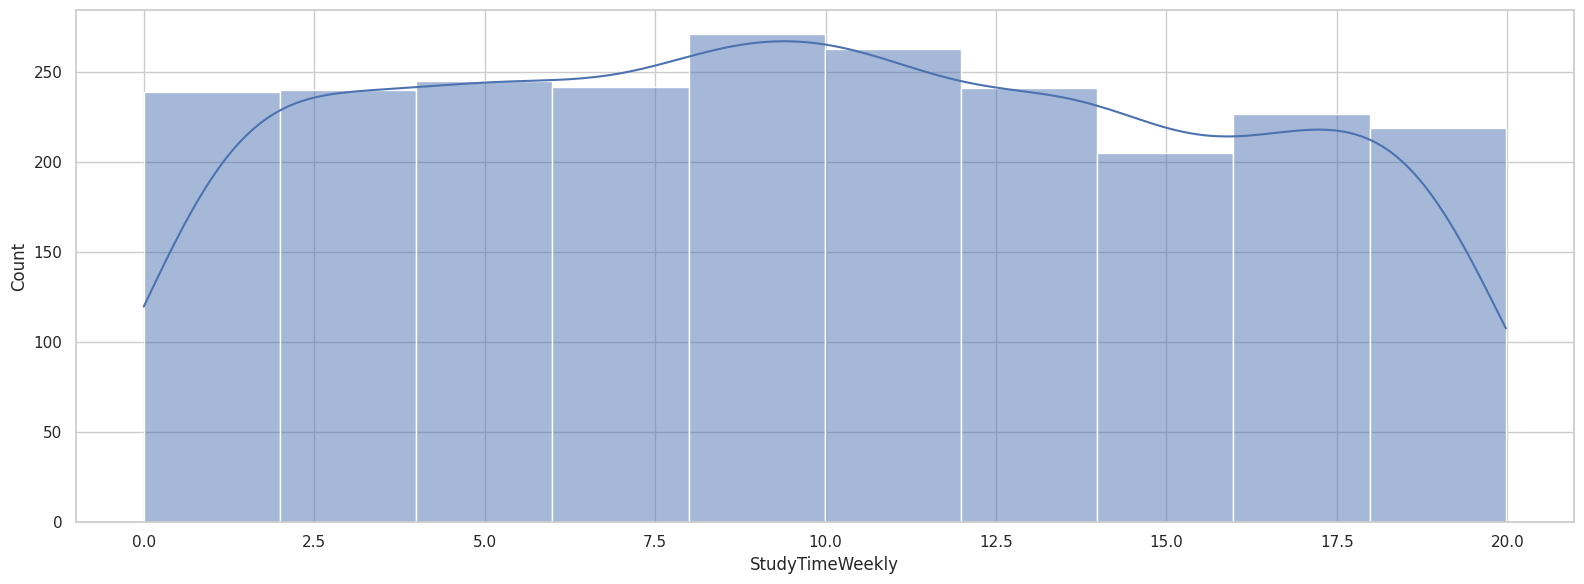

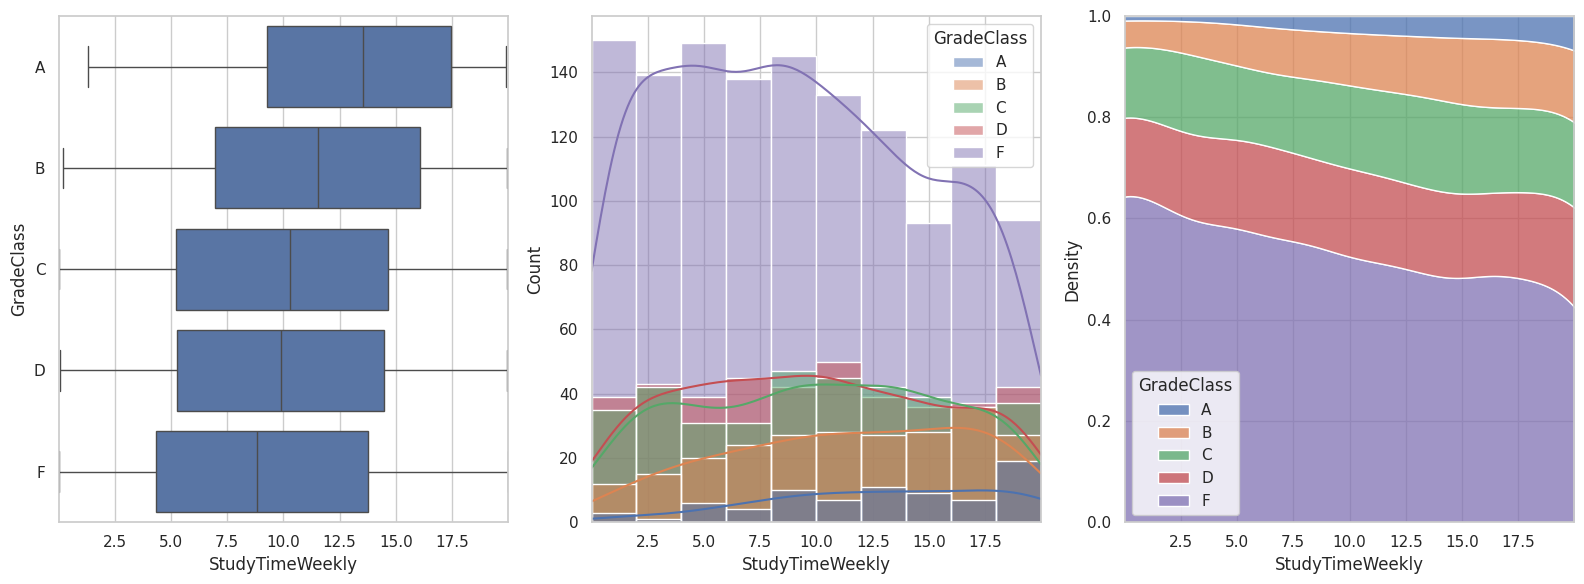

             count       mean       std       min       25%        50%  \
GradeClass                                                               
A             77.0  12.891884  5.056855  1.317843  9.285447  13.546079   
B            244.0  11.357646  5.401367  0.190779  6.942002  11.550768   
C            385.0  10.101910  5.586213  0.001057  5.213328  10.281614   
D            412.0   9.899795  5.655618  0.087192  5.270558   9.907730   
F           1274.0   9.138707  5.627681  0.004859  4.319421   8.828083   

                  75%        max  
GradeClass                        
A           17.442121  19.885760  
B           16.048477  19.948459  
C           14.634105  19.920256  
D           14.463444  19.939810  
F           13.747264  19.978094  


In [479]:
numerical_data_experiment(remapped_df, 'StudyTimeWeekly', bins=10)

#### Observation

- StudyTimeWeekly looks roughly uniform with a mild peak around ~9–12 hours.
- `A` Grade students have at tendency to study more than the other with the highest mean (12.89 hours on average, follows up by `B` - 11.36 hours, `C` - 10.1 hours, `D` - 9.9 hours,  `F`- 9.1 hours).
- The proportion of `C` and `D` Grade increases from 0–10 hours, peaks around 8–12 hours, then declines slightly between 10 and 20 hours.
- The share of `F` decreases as study time increases, while `A` and `B` increase.

In [480]:
print(remapped_df[(remapped_df['GradeClass'] == 'A') & (remapped_df['StudyTimeWeekly'] <= 2.5)])

      StudentID  Age  Gender         Ethnicity ParentalEducation  \
1023       2024   16  Female  African American            Higher   
1375       2376   15  Female         Caucasian        Bachelor's   
2354       3355   16    Male         Caucasian      Some College   

      StudyTimeWeekly  Absences Tutoring ParentalSupport Extracurricular  \
1023         1.317843         0      Yes        Moderate              No   
1375         1.820726         1      Yes            High              No   
2354         1.565490         4      Yes       Very High             Yes   

     Sports Music Volunteering       GPA GradeClass  
1023     No   Yes           No  3.592129          A  
1375    Yes   Yes           No  3.659836          A  
2354    Yes    No           No  3.979421          A  


- There are some students with `A` scores with their limited studying time per week (<2 hours). This might be some fast-learner, extraordinary students or they've known the knowledge before and might not be considered as outliners.

#### Implication

-  The more time you spend on studying, the better grade you may gain.

### 2.5.3. `Absences` Feature

#### Visualization

The ANOVA test.
F-statistic: 454.5697
P-value: 0.0000
Eta-squared: 0.8480
Significant difference in GPA across Absences.
\GPA vs Absences mean
Absences
0     3.401790
1     3.254577
3     3.092297
2     3.082517
4     2.971374
5     2.801303
6     2.757924
7     2.618820
9     2.526068
8     2.515815
10    2.440346
11    2.189109
12    2.130210
14    2.068891
13    2.048830
15    1.907235
16    1.770339
17    1.673405
18    1.566138
19    1.401635
20    1.389288
21    1.270249
22    1.123830
23    1.024511
24    0.945788
25    0.855207
26    0.720209
27    0.660363
29    0.609642
28    0.536255
Name: GPA, dtype: float64
\GPA vs Absences median
Absences
0     3.369584
1     3.268303
3     3.091715
2     3.089599
4     3.017353
5     2.845926
6     2.772519
7     2.626233
9     2.565347
8     2.507743
10    2.419029
11    2.190269
12    2.167941
14    2.056998
13    1.996513
15    1.916962
16    1.785052
17    1.672034
18    1.557688
19    1.434836
20    1.372840
21    1.333974
22    1.1

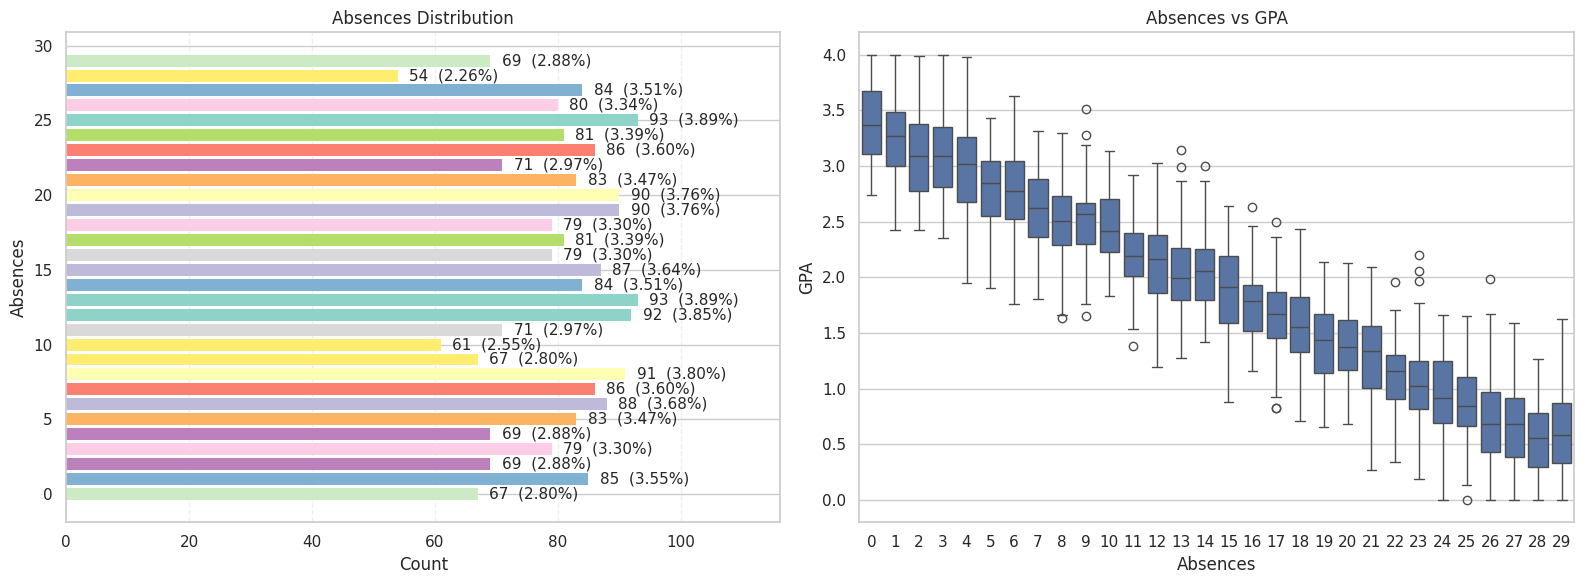

In [481]:
plot_stuff(remapped_df, 'Absences')

#### Observation

- The `Absences` Feature has a quite uniform distribution with `10` times in absence has the lowest portion (2.55%), `13` and `25` share the highest portion with 3.85% for each.
- The `Absences vs GPA` chart suggests that the more of time a student absences, the worse of academic performance they do. There are some potential outliers in 8/9/11/13/14/16/17/22/23/25/26 Absence but the data for each category is too little to strongly confirm that.
- Almost all the students that have >= 21 absence times get `F` Grade. Otherwise, students with `A` Grade shows up when the number of times they absences <= 10 with the peak frequency of `A` grade at 0 times of absences.
- One-way ANOVA suggests that `Absences` feature makes a huge effect on GPA (F=454.57, p=0). This sugests the differences in absence levels explaining ~85% of GPA variance across groups based on eta-squared.

#### Implication

- This feature has a significantly strong correlation to GPA (explains 84.8% GPA variance)
- This feature is very important, and can solely predict GPA with small residual errors, the 15% that it doesn't explain yet might come from other source.

### 2.5.4. Overall

- All of the Academic Engagement features quite correlated to GPA and doing from moderate to significant strong effect (especially Absences, explains ~85% GPA variance).
- StudyTimeWeekly should be checked more on correlation to GPA.

## 2.6. Extracurricular Engagement Analysis

### 2.6.1. `Music` Feature

Music feature shows that whether the student participates in music-related activities.

#### Visualization

The Welch's t-test on Music.
T-statistic: 3.5971
P-value: 0.0003
Eta-squared: 0.0054
Reject the null hypothesis: significant GPA difference between keys in Music feature.
\GPA vs Music mean
Music
Yes    2.041664
No     1.872969
Name: GPA, dtype: float64
\GPA vs Music median
Music
Yes    1.992299
No     1.871466
Name: GPA, dtype: float64


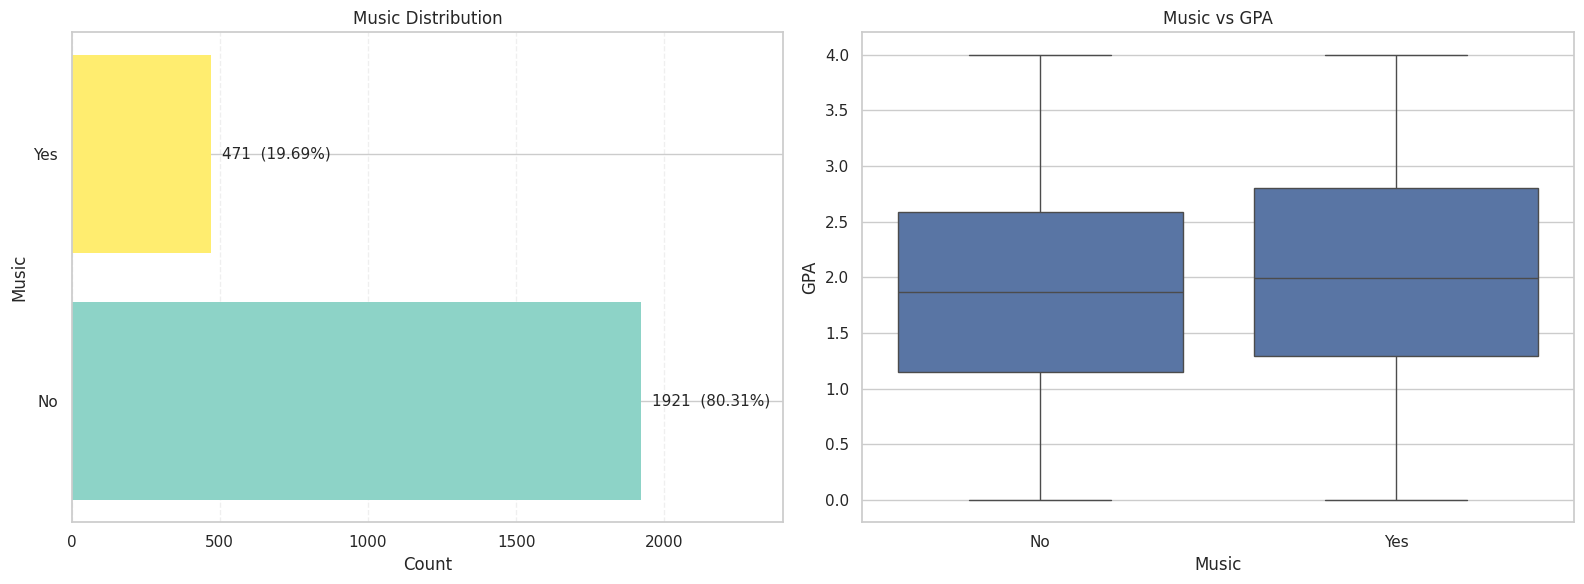

In [482]:
plot_stuff(remapped_df, 'Music')

#### Observation

- The majority of students (80.31%) not participate in Music-related activities, while 19.69% do.
- Students involved in Music have a higher average GPA (+0.17 points, 2.04 vs 1.87) compared to those not involved.
- Welch’s t-test (T ≈ 3.60, p = 0.0003) rejects the null hypothesis. 
- Eta-squares (0.0054) suggests that `Music` explains 0.54% GPA variance (very small effect).

#### Implication

- This feature has a very small correlation to GPA (explains 0.54% GPA variance)
- This feature can be deprioritized for the first model training.

### 2.6.2. `Extracurricular` Feature

#### Visualization

The Welch's t-test on Extracurricular.
T-statistic: -4.6086
P-value: 0.0000
Eta-squared: 0.0089
Reject the null hypothesis: significant GPA difference between keys in Extracurricular feature.
\GPA vs Extracurricular mean
Extracurricular
Yes    2.015357
No     1.838316
Name: GPA, dtype: float64
\GPA vs Extracurricular median
Extracurricular
Yes    2.009298
No     1.834749
Name: GPA, dtype: float64


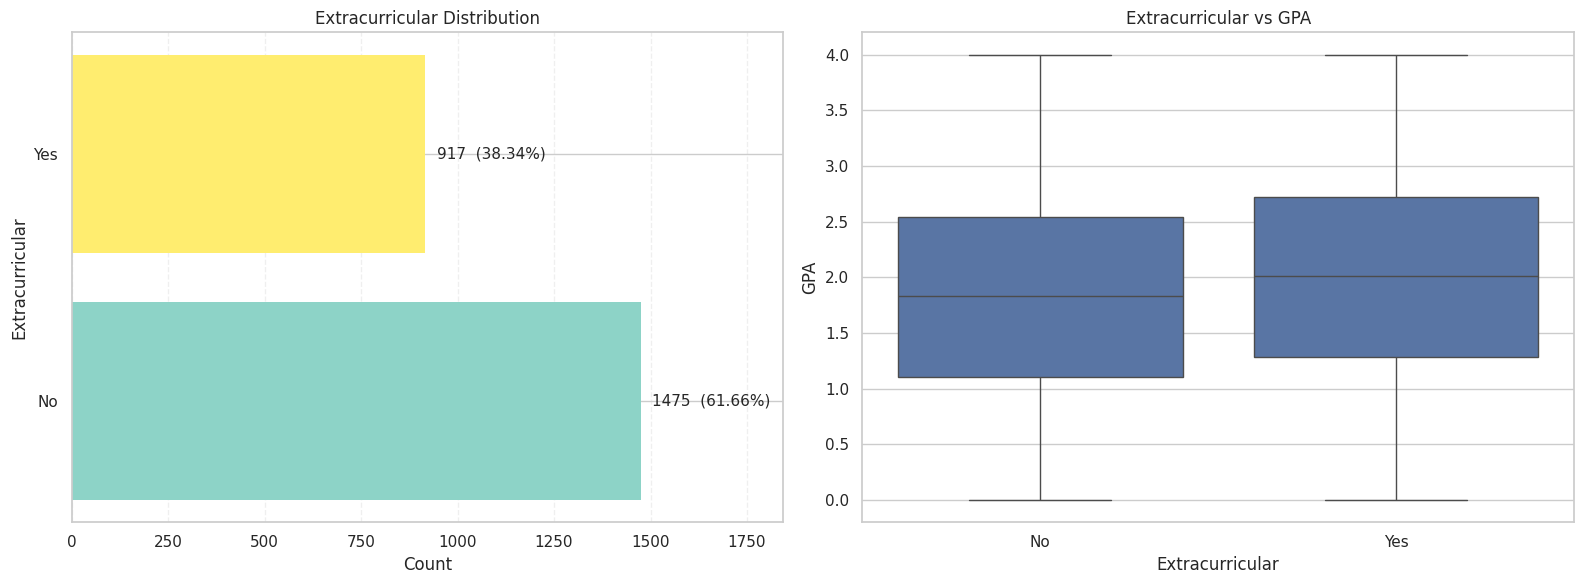

In [483]:
plot_stuff(remapped_df, 'Extracurricular')

`Extracurricular` Feature has the same observation and implication as `Music` Feature.

### 2.6.3. `Volunteering` Feature

#### Visualization

The Welch's t-test on Volunteering.
T-statistic: -0.1611
P-value: 0.8721
Eta-squared: 0.0000
Fail to reject the null hypothesis: no significant GPA difference between keys in Volunteering feature.
\GPA vs Volunteering mean
Volunteering
Yes    1.913089
No     1.904899
Name: GPA, dtype: float64
\GPA vs Volunteering median
Volunteering
No     1.894173
Yes    1.886079
Name: GPA, dtype: float64


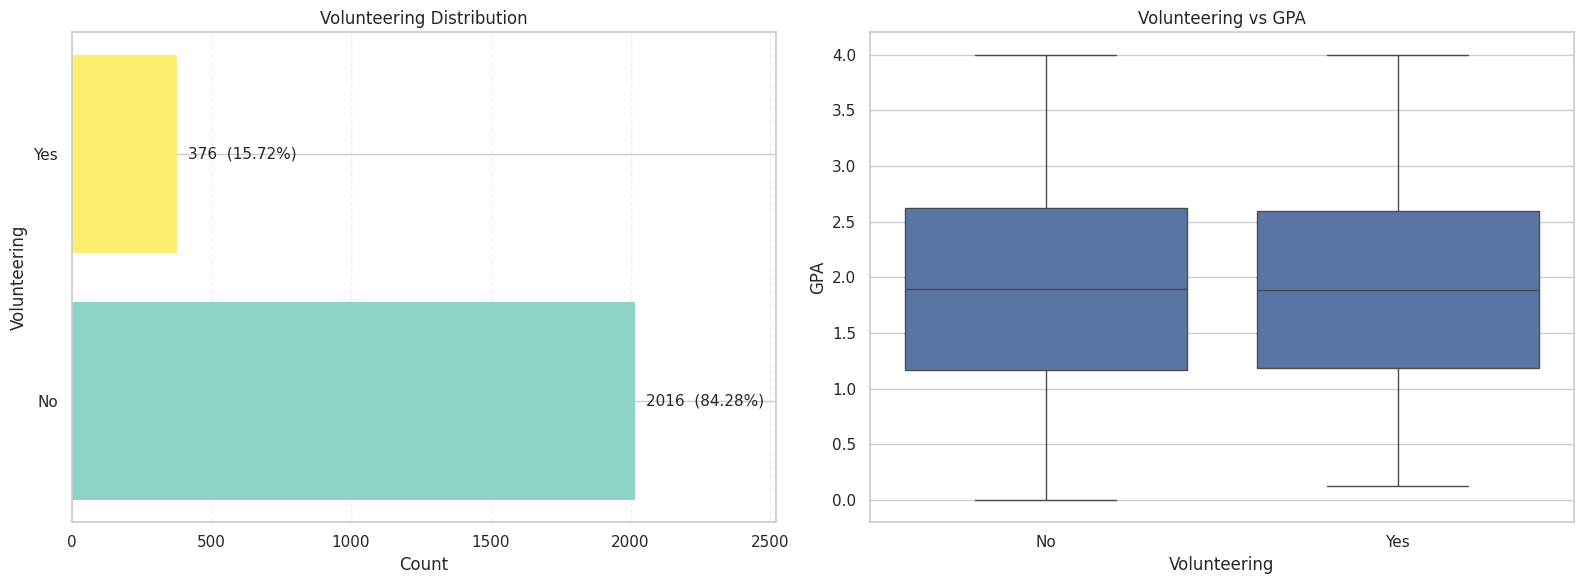

In [484]:
plot_stuff(remapped_df, 'Volunteering')

#### Observation

`Volunteering` Feature has the same observation as `Music` Feature, but the Welch's test shows suggests that there are no significant difference between Yes or No in Volunteering. Eta-squared ~ 0 suggests the  `Volunteering` doesn't explains anything in `GPA` variance. 

### 2.6.4. `Sports` Feature

#### Visualization

The Welch's t-test on Sports.
T-statistic: -2.8514
P-value: 0.0044
Eta-squared: 0.0033
Reject the null hypothesis: significant GPA difference between keys in Sports feature.
\GPA vs Sports mean
Sports
Yes    1.986381
No     1.871240
Name: GPA, dtype: float64
\GPA vs Sports median
Sports
Yes    1.948817
No     1.878406
Name: GPA, dtype: float64


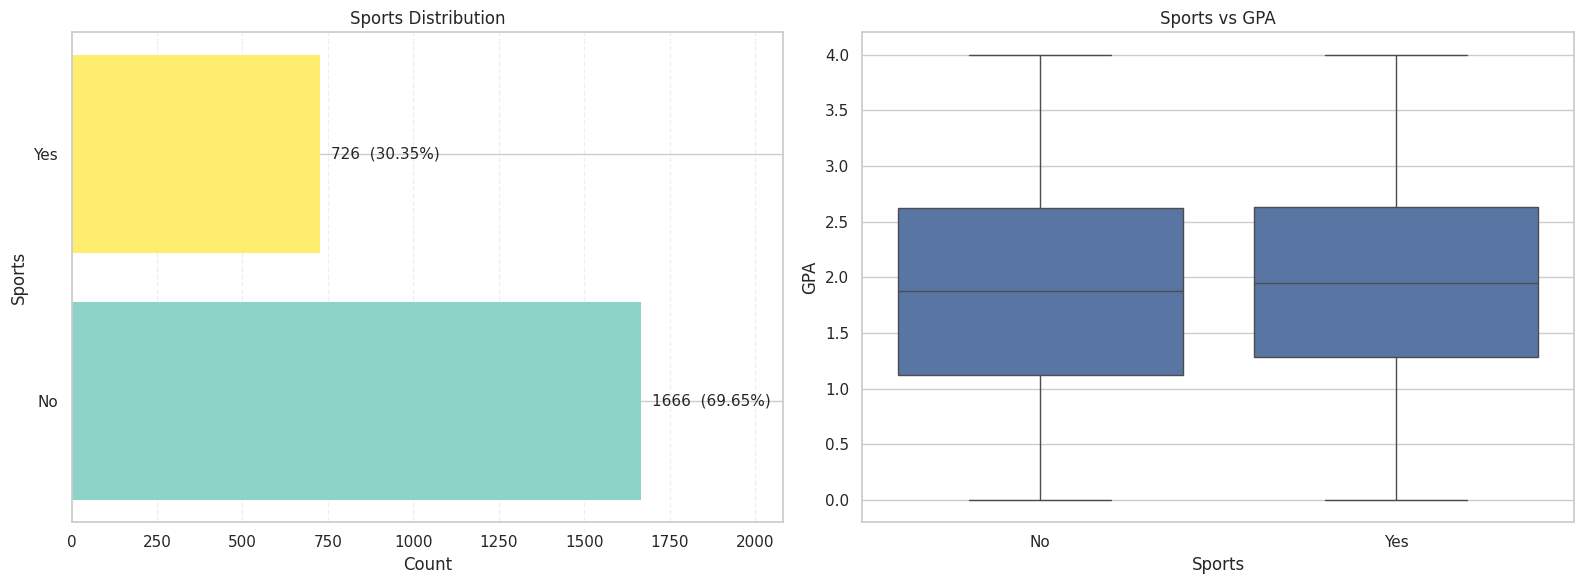

In [485]:
plot_stuff(remapped_df, 'Sports')

#### Observation

`Sports` Feature has the same observation as `Music` Feature.

### 2.6.5. Overall

## 2.7. Multivariate Analysis

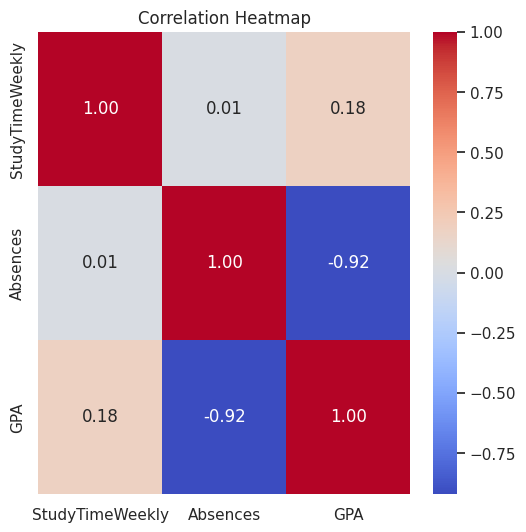

In [486]:
selected_num_cols = ['StudyTimeWeekly', 'Absences', 'GPA']
corr = remapped_df[selected_num_cols].corr()

plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

- As discovered above, `Absences` shows high correlation to `GPA` (-0.92) strongly suggesting the important of this features.
- StudyTimeWeekly have a moderate correlation (+0.18) to GPA.
- There's no correlation between 2 non-target features (< 0.1).

### 2.7.2. GPA & ParentalSupport & Tutoring

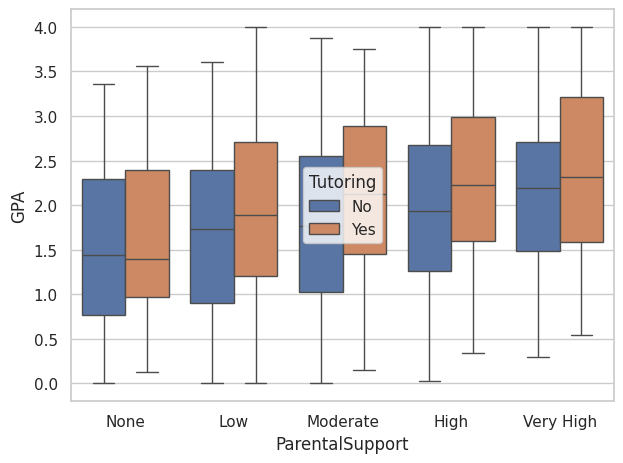

  ParentalSupport  count_Yes  mean_GPA_Yes  count_No  mean_GPA_No  delta_mean  \
0            None         61      1.658971       151     1.492119    0.166852   
1             Low        151      1.933297       338     1.676359    0.256938   
2        Moderate        226      2.124766       514     1.778492    0.346274   
3            High        206      2.245512       491     1.957196    0.288316   
4       Very High         77      2.392266       177     2.104226    0.288039   

     t_stat   p_value  reject_null_hypothesis  eta_squared  
0  1.210517  0.228599                   False     0.006799  
1  2.975682  0.003168                    True     0.017667  
2  4.898844  0.000001                    True     0.030557  
3  3.981431  0.000082                    True     0.022237  
4  2.266485  0.025074                    True     0.021968  


In [487]:
order = list(parental_support_map.values())
binary_multivariate_experiment(remapped_df, 'Tutoring', 'ParentalSupport', order=order)

#### Observation

In overall, students with Tutoring have higher mean (about 0.167-0.346 points).

__ParentalSupport__

__= None__
- Students with Tutoring has higher mean GPA (1.65 vs 1.49). Although the mean GPA is higher for tutored students, the evidence is insufficient to claim a real difference when parental support is absent. 
- T-test (T=1.21, p=0.22) suggests that there might have no difference in GPA between Tutoring or not. Tutoring does not show a reliable GPA benefit with the effect size is too small (eta_squared=0.0067).

__= Low‌/Moderate/High/Very High__
- Students with Tutoring achieve meaningfully higher GPAs than students without Tutoring.
- T-test suggests that Tutoring-ship does statistically make some benefits for students with at least 0.25 points differ from students without Tutoring. In moderate ParentalSupport, the students has the highest benefit on (T=4.99, p=0, eta-squared=0.03 (moderate effect)).

--> In conclusion, tutoring’s GPA advantage is not statistically reliable without parental support, and makes considerable change in GPA on students with at least Low parental support pointing out that `ParentalSupport` has relationship to `Tutoring`. 

#### Implication

- We can considered to create a new feature 'about is the current Tutoring effective', which is showed up by the parent involvement.

# 3. Data Split

## 3.0. Support function for Data Split

#### PSI

In [643]:
def psi_numeric(expected, actual, bins=10, eps=1e-6):
    qs = np.linspace(0, 1, bins+1)
    cuts = np.unique(np.quantile(expected, qs))
    if len(cuts) < 3: cuts = np.unique(np.quantile(expected, [0, .5, 1]))
    e_bin = np.clip(np.digitize(expected, cuts[1:-1], right=True), 0, len(cuts)-2)
    a_bin = np.clip(np.digitize(actual,   cuts[1:-1], right=True), 0, len(cuts)-2)
    e_prop = np.maximum(np.bincount(e_bin, minlength=len(cuts)-1).astype(float), eps); e_prop /= e_prop.sum()
    a_prop = np.maximum(np.bincount(a_bin, minlength=len(cuts)-1).astype(float), eps); a_prop /= a_prop.sum()
    return float(np.sum((e_prop - a_prop) * np.log(e_prop / a_prop)))

In [644]:
def psi_categorical(expected, actual, eps=1e-6):
    e = pd.Series(expected).astype(str).value_counts(); a = pd.Series(actual).astype(str).value_counts()
    cats = e.index.tolist(); e_total, a_total = e.sum(), a.sum(); psi = 0.0
    for c in cats + ["__OTHER__"]:
        e_p = (e.get(c,0)/e_total) if c in cats else 0.0
        a_p = (a.get(c,0)/a_total) if c in a.index else (a[~a.index.isin(cats)].sum()/a_total if c=="__OTHER__" else 0.0)
        e_p, a_p = max(e_p, eps), max(a_p, eps)
        psi += (e_p - a_p) * np.log(e_p / a_p)
    return float(psi)

In [645]:
def psi_interpretation(psi_result: float) -> str:
    if psi_result < 0.1:
        return "SAFE"
    elif psi_result <= 0.25:
        return "MODERATE"
    else:
        return "HIGH"

In [646]:
def psi_ksi(expected: pd.DataFrame, actual: pd.DataFrame, eps: float=1e-6) -> pd.DataFrame:
    num_feats = list(expected.select_dtypes('number').columns)
    cat_feats = list(expected.select_dtypes('category').columns) 
    feats = num_feats + cat_feats 
    result = []
    
    for feat in feats:
        args = [expected[feat], actual[feat]]
        
        D, p = stats.ks_2samp(*args)
        psi_result = psi_numeric(*args) if feat in num_feats else \
                     psi_categorical(*args) 
        result.append({
            'feature_name': feat,
            'ks-stats': round(D,4),
            'ks-p-value': round(p,4),
            'psi_result': psi_result,
            'psi_interpret': psi_interpretation(psi_result)
        })
    
    return pd.DataFrame(result)

## 3.1. Overview

- There's no time or sequence column or any time-related columns in this dataset. Moreover, there's no duplicated `StudentID` which strongly suggests that the dataset is independent in time.
- Selected data split: random split.
- To exchange the problem to time-series, It would be necessary to have some time-stamps on dataset.

In [647]:
X = df.drop(columns=['GPA', 'GradeClass', 'StudentID'])
y = df['GPA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, shuffle=True)

In [648]:
X_train

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
361,15,1,0,3,7.019512,9,0,1,1,0,0,1
1583,18,0,3,1,9.837519,10,1,3,0,0,0,1
630,15,1,1,0,14.389199,3,1,1,0,0,0,0
993,18,1,2,1,3.895876,8,0,2,0,1,0,0
2360,18,0,1,3,12.684862,20,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1638,15,0,1,0,13.092424,13,1,1,0,0,0,0
1095,16,0,0,2,2.159249,19,0,4,0,1,0,0
1130,16,1,0,2,3.572578,14,1,2,1,1,0,0
1294,18,0,3,2,4.402585,20,0,3,0,0,0,0


## 3.2. Check the split

| PSI Value | Interpretation |
|-----------|----------------|
| < 0.1     | No significant change (stable distribution) |
| 0.1 - 0.25 | Moderate shift (monitor closely) | 
| > 0.25 | Significant shift (potential model degradation) |

Source: [
Population Stability Index (PSI) - Geeksforgeeks](https://www.geeksforgeeks.org/data-science/population-stability-index-psi/)

### 3.2.1. Target (GPA)

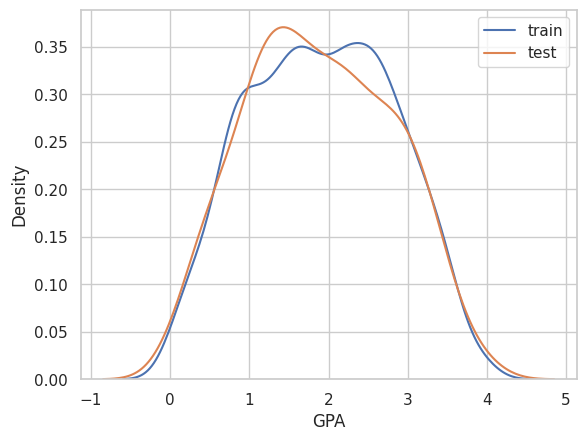

In [649]:
sns.kdeplot(data=y_train, label='train')
sns.kdeplot(data=y_test, label='test')
plt.legend()
plt.show()

In [650]:
print(f'The standard deviation of target (train): {y_train.std():.4f}')
print(f'The standard deviation of target (test): {y_test.std():.4f}')

The standard deviation of target (train): 0.9152
The standard deviation of target (test): 0.9159


- There is similar in distribution of target feature (GPA) between the train_set (blue) and  test_set (orange), though the test set is quite skewed to left.
- The model performance on test set (unknown data) can be worse, GPA prediction might have high residual error at 1-2 GPA ranges.


In [651]:
D, p = stats.ks_2samp(y_train, y_test)
print('Null Hypothesis: y_train & y_test have the same distribution.')
print(f"KS D={D:.3f}, p-value={p:.3f}")
print(psi_ksi(pd.DataFrame(y_train), pd.DataFrame(y_test)))

Null Hypothesis: y_train & y_test have the same distribution.
KS D=0.036, p-value=0.821
  feature_name  ks-stats  ks-p-value  psi_result psi_interpret
0          GPA    0.0355      0.8209      0.0185          SAFE



__Kolmogorov-Smirnov Test (KS):__
- The statistic is relatively small (0.0355), suggesting that y_train's distribution and y_test's distribution are close.
- Since the p-value (0.8209), is higher than the chosen significance level (0.05), we fail to reject the null hypothesis. Therefore, we cannot conclude that two samples have identical distribution.

__Population Stability Index (PSI):__
- This metric shows that there is no significant change in distribution between y_train and y_test, suggesting the stable distribution.

### 3.2.2. Features

In [652]:
psi_ksi(X_train, X_test)

,feature_name,ks-stats,ks-p-value,psi_result,psi_interpret
0,Age,0.0182,0.9999,0.000292,SAFE
1,Gender,0.0603,0.2074,0.000000,SAFE
2,Ethnicity,0.0240,0.9928,0.007727,SAFE
3,ParentalEducation,0.0599,0.2142,0.029098,SAFE
4,StudyTimeWeekly,0.0495,0.4281,0.036447,SAFE
5,Absences,0.0467,0.5025,0.030276,SAFE
6,Tutoring,0.0091,1.0000,0.000395,SAFE
7,ParentalSupport,0.0452,0.5439,0.011968,SAFE
8,Extracurricular,0.0340,0.8585,0.000000,SAFE
9,Sports,0.0034,1.0000,0.000000,SAFE



__Kolmogorov-Smirnov Test (KS):__
- Results form features for continous and ordinal category features shows that there's no significant difference between train and test set in each features.
- For nominal category features (Gender, Sports, Extracurricular, Tutoring, Ethnicity, Volunteering), KS is not meaningful for this test and they're considered to check the PSI solely.

__Population Stability Index (PSI):__
- This metric shows that there is no significant change in distribution between each features in X_train and X_test, suggesting the stable distribution for every features.

### Conclusion

The stable generalization is expected: metric_train <= metric_val ~  metric_test

About spliting data for model training, my strategy is 5-Fold Cross-Validation due to the limited records of ML

# 4. Data Pipeline

In [498]:
class CreateCustomFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass 

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X["IsEffectiveTutoring"] = X['Tutoring'] * (X['ParentalSupport'] != 0).astype(int)
        return X

In [499]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, is_keep=True):
        self.columns = columns
        self.is_keep = is_keep

    def fit(self, X, y=None):
        if self.columns is not None:
            missing = [c for c in self.columns if c not in X.columns]
            if missing:
                raise ValueError(f"ColumnSelector: missing columns: {missing}")
        return self

    def transform(self, X, y=None):
        actual_selected = self.columns if self.is_keep else [col for col in X.columns if col not in self.columns]
        for col in X.columns:
            if col not in actual_selected:
                X[col] = 0 # remove the col but keep names
        return X

In [500]:
from sklearn.feature_selection import mutual_info_regression

In [501]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [656]:
y = df['GPA']
X["IsEffectiveTutoring"] = X['Tutoring'] * (X['ParentalSupport'] != 0).astype(int)
df["IsEffectiveTutoring"] = df['Tutoring'] * (df['ParentalSupport'] != 0).astype(int)


In [657]:
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=X.columns)

Absences               0.887193
IsEffectiveTutoring    0.035741
Tutoring               0.027562
ParentalSupport        0.025736
Age                    0.018146
Extracurricular        0.016309
Sports                 0.005158
Volunteering           0.004864
Music                  0.004513
StudyTimeWeekly        0.003669
ParentalEducation      0.003281
Gender                 0.000000
Ethnicity              0.000000
dtype: float64


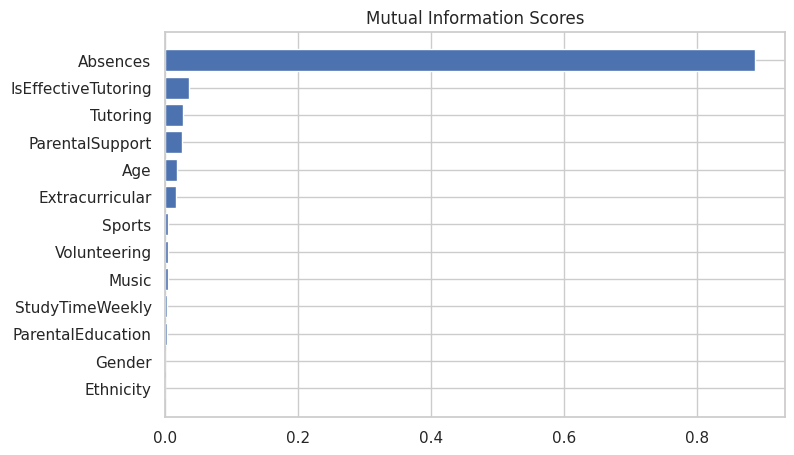

In [658]:
mi_scores = mi_scores.sort_values(ascending=False)
print(mi_scores)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)


In [659]:
if 'GPA' in numerical_cols:
    numerical_cols.remove('GPA')
if 'StudentID' in numerical_cols:
    numerical_cols.remove('StudentID')

numerical_cols

['StudyTimeWeekly', 'Absences']

In [660]:
non_ord_cat_cols = binary_cat_cols + nominal_cat_cols
non_ord_cat_cols

['Gender',
 'Tutoring',
 'Extracurricular',
 'Sports',
 'Music',
 'Volunteering',
 'Ethnicity']

In [661]:
ordinal_cat_cols = ['ParentalEducation', 'ParentalSupport', 'Age'] 
print(ordinal_cat_cols, end='\n\n')

ordinal_cat_orders = [
    ["None", "High School", "Some College", "Bachelor's", "Higher"],  # ParentalEducation
    ["None", "Low", "Moderate", "High", "Very High"],                 # ParentalSupport
    [15, 16, 17, 18],                                                 # Age
]
for i in range(len(ordinal_cat_orders)):
    print(ordinal_cat_cols[i],':', ordinal_cat_orders[i])


['ParentalEducation', 'ParentalSupport', 'Age']

ParentalEducation : ['None', 'High School', 'Some College', "Bachelor's", 'Higher']
ParentalSupport : ['None', 'Low', 'Moderate', 'High', 'Very High']
Age : [15, 16, 17, 18]


#### Numerical Pipeline

In [662]:
num_df = X_train[numerical_cols]
num_df

,StudyTimeWeekly,Absences
361,7.019512,9
1583,9.837519,10
630,14.389199,3
993,3.895876,8
2360,12.684862,20
...,...,...
1638,13.092424,13
1095,2.159249,19
1130,3.572578,14
1294,4.402585,20


In [663]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])
numerical_pipeline

,steps,"[('imputer', ...), ('std_scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


KS-statistic=0.9085, p-value=0.0000


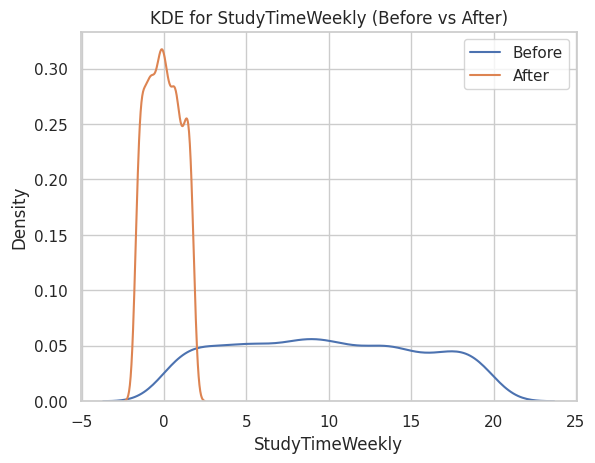

KS-statistic=0.9370, p-value=0.0000


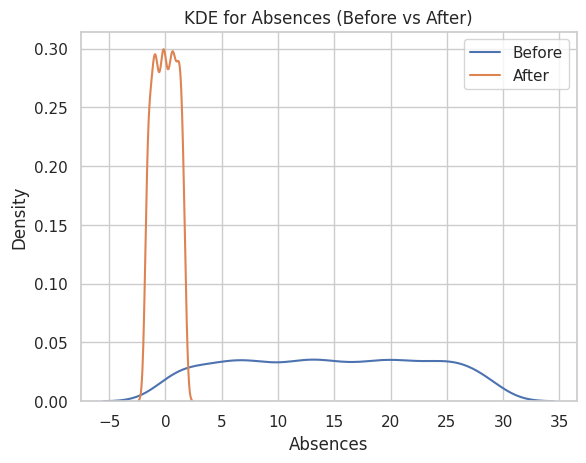

In [664]:
numerical_pipeline.set_output(transform='pandas')
num_df_modded = numerical_pipeline.fit_transform(num_df)

for col in numerical_cols:
    stat, p = stats.ks_2samp(num_df[col], num_df_modded[col])
    print(f"KS-statistic={stat:.4f}, p-value={p:.4f}")
    sns.kdeplot(data=num_df, x=col, label='Before')
    sns.kdeplot(data=num_df_modded, x=col, label='After')
    plt.title(f"KDE for {col} (Before vs After)")
    plt.legend()
    plt.show()

- KS results indicate etreme shift after performing transformation, which are expected effects.

#### Nominal & binary: non-ordinal categorical pipeline

In [665]:
non_ord_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])
non_ord_cat_pipeline

,steps,"[('imputer', ...), ('one_hot_encoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'most_frequent'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [667]:
print(non_ord_cat_cols, end='\n\n')
df_cat_non_ord = remapped_df[non_ord_cat_cols]
df_cat_non_ord_modded = non_ord_cat_pipeline.fit_transform(df_cat_non_ord)
print(f'Number of non-ordinal category columns: {len(non_ord_cat_cols)}')
print(f'Number of new non-ordinal category columns: {df_cat_non_ord_modded.shape[1]}')
print(f'Number of new non-ordinal category columns created: {df_cat_non_ord_modded.shape[1] - df_cat_non_ord.shape[1]}')

['Gender', 'Tutoring', 'Extracurricular', 'Sports', 'Music', 'Volunteering', 'Ethnicity']

Number of non-ordinal category columns: 7
Number of new non-ordinal category columns: 10
Number of new non-ordinal category columns created: 3


### Ordinal category Pipeline

In [668]:
df_cat_ord = remapped_df[ordinal_cat_cols]
df_cat_ord.head(10)

,ParentalEducation,ParentalSupport,Age
0,Some College,Moderate,17
1,High School,Low,18
2,Bachelor's,Moderate,15
3,Bachelor's,High,17
4,Some College,High,17
5,High School,Low,18
6,High School,High,15
7,Higher,Low,15
8,None,Moderate,17
9,High School,High,16


In [669]:
ord_encoder = OrdinalEncoder(categories=ordinal_cat_orders)
df_cat_ord_modded = ord_encoder.fit_transform(df_cat_ord)
df_cat_ord_modded[:10]

array([[2., 2., 2.],
       [1., 1., 3.],
       [3., 2., 0.],
       [3., 3., 2.],
       [2., 3., 2.],
       [1., 1., 3.],
       [1., 3., 0.],
       [4., 1., 0.],
       [0., 2., 2.],
       [1., 3., 1.]])

Looks like this ordinal encoder's setting works and encodes correctly.

In [670]:
ordinal_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0, )),
    ('ordinal_encoder', OrdinalEncoder(
        # categories=ordinal_cat_orders,
        handle_unknown="use_encoded_value",
        unknown_value=-1
    )),
])
ordinal_cat_pipeline

,steps,"[('imputer', ...), ('ordinal_encoder', ...)]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,0
,copy,True
,add_indicator,False
,keep_empty_features,False
,categories,'auto'


In [671]:
preproc_linear = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('ordinal_cat', ordinal_cat_pipeline, ordinal_cat_cols),
        ('non_ordinal_cat', non_ord_cat_pipeline, non_ord_cat_cols),
    ],
    remainder='passthrough'
)
preproc_linear

,transformers,"[('num', ...), ('ordinal_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


Tree-based models don't need StandardScaler so I remove it.

In [673]:
preproc_tree = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),
        ('ordinal_cat', ordinal_cat_pipeline, ordinal_cat_cols),
        ('non_ordinal_cat', non_ord_cat_pipeline, non_ord_cat_cols),
    ],
    remainder='passthrough'
)
preproc_tree

,transformers,"[('num', ...), ('ordinal_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [674]:
Xtr = preproc_linear.fit_transform(X_train)
assert (df_cat_ord_modded.shape[1] + df_cat_non_ord_modded.shape[1] + num_df_modded.shape[1] == Xtr.shape[1])
Xtr

array([[-0.48048735, -0.65258464,  3.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01690982, -0.53431894,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.82031205, -1.36217881,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.0888946 , -0.06125616,  2.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.94239271,  0.64833801,  2.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.76146571,  1.47619788,  2.        , ...,  1.        ,
         0.        ,  0.        ]], shape=(2033, 15))

# 5. Modeling

### 5.1. Support functions

#### Visualization

In [675]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [676]:
def cv_evaluate_model(pipe, X, y, model_name):
    rmse_train, mae_train, r2_train = [], [], []
    rmse_val, mae_val, r2_val = [], [], []
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx] 
        
        # Train model
        pipe.fit(X_train, y_train)
        
        # Evaluate model on training set
        y_pred_val = pipe.predict(X_val)
        args = [y_val, y_pred_val]
        rmse_val.append(RMSE(*args))
        mae_val.append(MAE(*args))
        r2_val.append(R2(*args))
        
        # Evaluate model on validation set
        y_pred_train = pipe.predict(X_train)
        args = [y_train, y_pred_train]
        rmse_train.append(RMSE(*args))
        mae_train.append(MAE(*args))
        r2_train.append(R2(*args))
        
        
    print(f'5-Fold CV results {model_name}:')        
    metrics = pd.DataFrame(
        {"rmse_train": rmse_train, 'rmse_val': rmse_val, 
         "mae_train": mae_train, 'mae_val': mae_val,
         "r2_train": r2_train, 'r2_val': r2_val})
    print(metrics.describe().T) 
    
    print(f'Train RMSE: {metrics["rmse_train"].mean():.4f} ± {metrics["rmse_train"].std():.4f}')
    print(f'Val RMSE: {metrics["rmse_val"].mean():.4f} ± {metrics["rmse_val"].std():.4f}')
    print(f'Train R²: {metrics["r2_train"].mean():.4f}')
    print(f'Val R²: {metrics["r2_val"].mean():.4f}')


In [700]:

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test) 
    # Calculate metrics
    args = [y_test, y_pred]
    mae = MAE(*args)
    rmse = RMSE(*args)
    r2 = R2(*args)
    me = ME(*args)
    psi = psi_numeric(*args)
    # Print results
    print(f"\n--- {model_name} metrics on test set ---")
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R2: {r2:.4f}')
    print(f'ME: {me:.4f}')
    print(f'PSI: {psi:.4f}')    
    f, axs = plt.subplots(1, 2, figsize=(16, 6))
    PredictionErrorDisplay.from_predictions(
        y_test, y_pred, subsample=5000, 
        scatter_kwargs={'alpha':0.2},
        ax=axs[0],
        kind='residual_vs_predicted',
    )
    
    PredictionErrorDisplay.from_predictions(
        y_test, y_pred, subsample=5000, 
        scatter_kwargs={'alpha':0.2},
        ax=axs[1],
        kind='actual_vs_predicted', 
    )
    
    results = {
        'model_name': model_name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2, 
        'max_error': me,
        'psi': psi
    }
    return results
# Source: Giangcthh (with some modifications).

#### Create KFold Splitter

In [678]:
def get_coeff(pipe):
    feature_names = pipe.named_steps["prep"].get_feature_names_out()
    coefs = pipe.named_steps["model"].coef_
    
    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": coefs
    }).sort_values(by="Coefficient", key=abs, ascending=False)

    coef_df = coef_df.reindex(coef_df.index)
    coef_df = coef_df.reset_index(drop=True)
    coef_df.index = coef_df.index + 1 
    print(coef_df)

In [680]:
def get_feat_importance(pipe):
    if 'prep' in pipe.named_steps:
        feature_names = pipe.named_steps["prep"].get_feature_names_out()
    else:
        feature_names = X_train.columns
    importances = pipe[-1].feature_importances_
    
    df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)
    
    return df

#### RandomSearchCV Helper

In [681]:
common_random_search_args = {
    'n_iter': 200,
    'cv': 5,
    'scoring': 'r2',
    'random_state': SEED,
    'n_jobs': -1,
    'verbose': 0
}
# total = 1000 fits btw

In [682]:
def run_random_search(estimator, params):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=params,
        **common_random_search_args
    )
    with tqdm_joblib(tqdm(desc='RandomizedSearchCV', total=1000)) as progress:
        random_search.fit(X_train, y_train)
    return random_search

### 5.2. Pre Modeling

In [685]:
nnz   = np.count_nonzero(Xtr)
total = Xtr.shape[0] * Xtr.shape[1]
density = nnz / total 
sparity = 1 - density 
result = {
    "shape_before": X_train.shape,
    "shape_after": Xtr.shape,
    "non_zero": int(nnz),
    "density": f'{density * 100:.2f}%',
    "sparsity": f'{sparity * 100:.2f}%',
    "new_columns_from_cat": Xtr.shape[1] - X_train.shape[1]  # quick proxy
}
result


{'shape_before': (2033, 12),
 'shape_after': (2033, 15),
 'non_zero': 15062,
 'density': '49.39%',
 'sparsity': '50.61%',
 'new_columns_from_cat': 3}

In [686]:
print(f'The standard deviation of target (train): {y_train.std():.4f}')
print(f'The standard deviation of target (test): {y_test.std():.4f}')

The standard deviation of target (train): 0.9152
The standard deviation of target (test): 0.9159



| GradeClass Code | Grade Label | Range       |
|-----------------|-------------|--------------------|
| **0**           | A           | GPA ≥ 3.5          | 
| **1**           | B           | 3.0 ≤ GPA < 3.5    |
| **2**           | C           | 2.5 ≤ GPA < 3.0    |
| **3**           | D           | 2.0 ≤ GPA < 2.5    | 
| **4**           | F           | GPA < 2.0          |

__Problem goal:__ Predicting GPA
__Metrics:__
- Primary: 
    - Mean Absolute Error (MAE): I select it because it is more easy to explain the model for academic institutes.
        - Good threshold: <= 0.50 (not wrong-predicted 2 ranks).
- Secondary: 
    Root Mean Squared Error (RMSE), the higher residual error gains. the higher penalty gains. 
        - Reason: Just in case MAE are similar.
        - the RMSE metric is selected as primary metric since RMSE squares residuals and thus emphasizes large deviations. This reflects our objective: large mistakes can lead to missed or inappropriate interventions for at-risk students, so we weight them more heavily . evaluation.
        - Good threshold: metric << 0.91 (standard deviation on both train and test set), models should predict better than dummy guesses.
    
    - R^2: For the quick look then I compare model performances, how many of GPA variance that features explain?
        - Good threshold: >= 0.90, because `Absences` itself explains ~85% of GPA variance, and there's some useful features too. (base on the EDA).
    - Max error (ME): Just for checking how bad a model can mispredict on outliers.
        - The max error in my opinion must not over 0.5 for the simple reason that students' ClassGrade might mispredicted at least 2 ranks.



__Selected Models__

- Experiment 1 - Linear Regression as a baseline model: 

    - Reason: For the simple reason that there is a highly correlated feature - `Absences` and this feature can solely explain ~85% GPA variance, suggesting the linearity.
    - Strengths: Simple, straigh-forward, Cheap computation.
    - Weakness: Sensitive to outliners, which has a very small portion in this dataset so I think it's okay to use. Moreover, It might not have ability to tackle non-linearity.
- Experiment 2 - Random Forest Regressor:

    - Reason: It is possible to have some potential non-linearity in this dataset.
    - Strenghs: The reason.
    - Weaknesses: Easy to be overfitted so that the hyperparameter optimization is seriously important. It cannot completely handle information from category features, and computationally expensive.

- Experiment 3 - CatBoost:
    - Reason: Just like Experiment 2.
    - Strengths: Ability to confront category features, which have high portion in this dataset. Moreover, it is not necessary to preprocess the data. It less likely to be overfitted in comparison with Random Forest Regressor.
    - Weaknesses: I don't know.
- Experiment ...: there are some voting-like models. I just randomly test some of above combination.
    - Weaknesses: For sure it's computational expensive. I will consider to deploy one of these on production if and only if the performance of them are better than Linear Regression about ~ 0.5 RMSE.

### 5.3. Model Training and Evaluation

#### Experiment 0: Dummy Regression (Always predict GPA median)

I'm just curious can the dummy regression perform well with this problem.


--- Linear Regression metrics on test set ---
MAE: 0.7726
RMSE: 0.9149
R2: -0.0006
ME: 2.0955
PSI: 17.8038


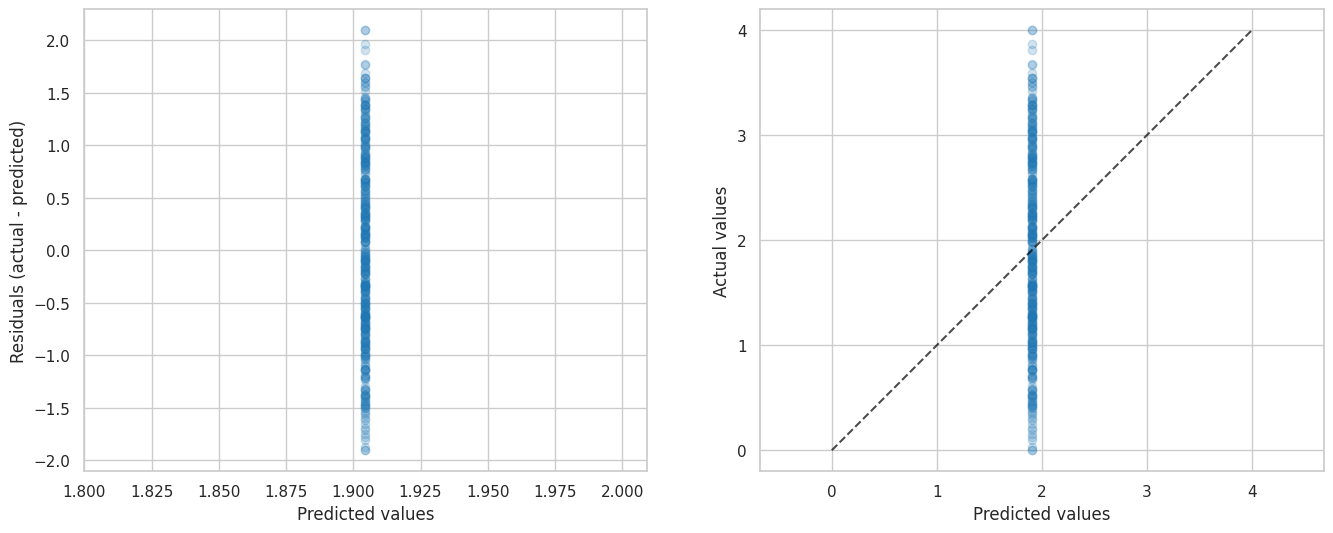

In [687]:
dummy_pipe = Pipeline([
    ('model', dummy.DummyRegressor(strategy='median')),
])
dummy_pipe.fit(X_train, y_train)
lr_results = evaluate_model(dummy_pipe, X_test, y_test, "Linear Regression")

#### Experiment 1: Linear Regression as a Baseline model

In [715]:
lr_pipe = Pipeline([
    ('feat_eng', CreateCustomFeatures()),
    # ('select_col', ColumnSelector(, is_keep=False)),
    ('prep', preproc_linear),
    ('model', linear_model.LinearRegression()),
])
lr_pipe

,steps,"[('feat_eng', ...), ('prep', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ordinal_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


5-Fold CV results Linear Regression:
            count      mean       std       min       25%       50%       75%  \
rmse_train    5.0  0.195983  0.002554  0.193205  0.194961  0.195472  0.196165   
rmse_val      5.0  0.197601  0.010453  0.180347  0.197406  0.200091  0.201819   
mae_train     5.0  0.158849  0.002165  0.156494  0.157714  0.158483  0.159302   
mae_val       5.0  0.160381  0.008544  0.146991  0.158275  0.161917  0.165304   
r2_train      5.0  0.954084  0.001750  0.951575  0.953880  0.953910  0.954603   
r2_val        5.0  0.952795  0.007222  0.942564  0.950972  0.953728  0.954001   

                 max  
rmse_train  0.200110  
rmse_val    0.208341  
mae_train   0.162251  
mae_val     0.169420  
r2_train    0.956453  
r2_val      0.962709  
Train RMSE: 0.1960 ± 0.0026
Val RMSE: 0.1976 ± 0.0105
Train R²: 0.9541
Val R²: 0.9528

--- Linear Regression metrics on test set ---
MAE: 0.1544
RMSE: 0.1964
R2: 0.9539
ME: 0.8856
PSI: 0.0113


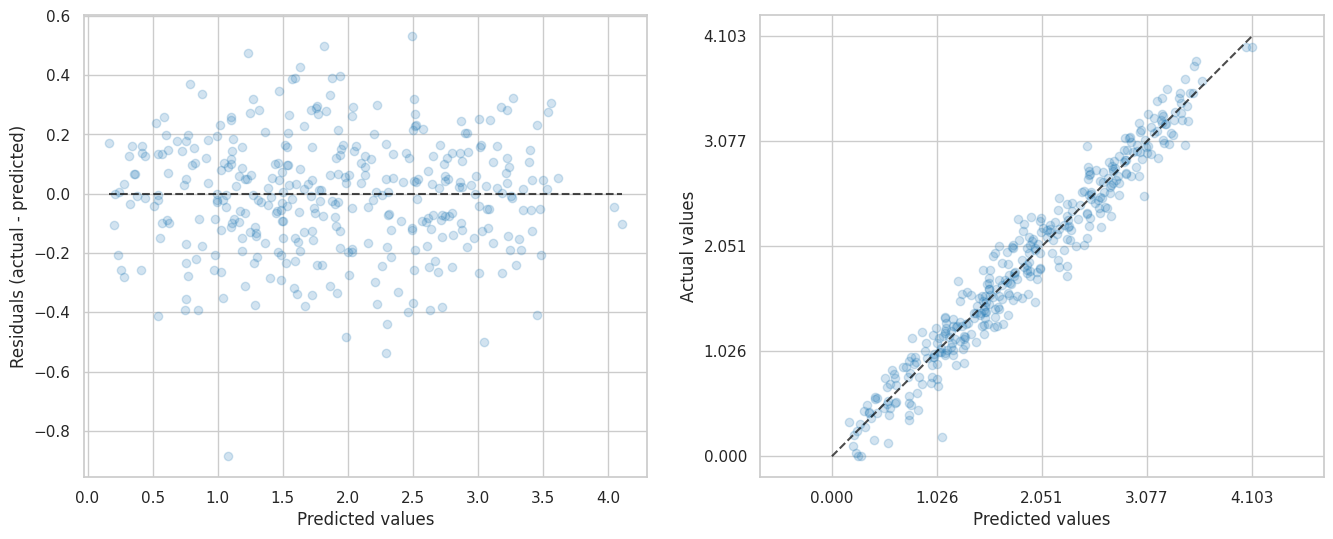

In [716]:
cv_evaluate_model(lr_pipe, X_train, y_train, 'Linear Regression')
lr_pipe.fit(X_train, y_train)
lr_results = evaluate_model(lr_pipe, X_test, y_test, 'Linear Regression')

- The small gap between training and validation metrics indicates no evidence of overfitting. The performance in both sets are identical
On the test set, the model maintains similar performance (RMSE = 0.1964, R² = 0.9539), confirming strong generalization.
- PSI looks pretty good, suggesting the stable of the model.

In [530]:
get_coeff(lr_pipe)

                               Feature  Coefficient
1                        num__Absences    -0.843400
2          non_ordinal_cat__Tutoring_1     0.277315
3         non_ordinal_cat__Ethnicity_2     0.275920
4         non_ordinal_cat__Ethnicity_1     0.275257
5         non_ordinal_cat__Ethnicity_3     0.271371
6         non_ordinal_cat__Ethnicity_0     0.265275
7   non_ordinal_cat__Extracurricular_1     0.188258
8            non_ordinal_cat__Sports_1     0.186412
9                 num__StudyTimeWeekly     0.165256
10            non_ordinal_cat__Music_1     0.154333
11        ordinal_cat__ParentalSupport     0.149260
12      remainder__IsEffectiveTutoring    -0.020666
13           non_ordinal_cat__Gender_1     0.014489
14     non_ordinal_cat__Volunteering_1    -0.008342
15                    ordinal_cat__Age    -0.006395
16      ordinal_cat__ParentalEducation     0.000256


__Feature groups:__
| Type | Label | List |
|------|-------|------|
| Demographics | A | `Age`, `Gender`, `ParentalEducation`, `ParentalSupports`, `Ethnicity`|
| Academics Engagement | B| `Absences`, `StudyTimeWeekly`, `Tutoring` |
| Extracurricular Activities | C | `Sports`, `Music`, `Volunteering`, `Extracurricular` |

__Observation:__
- `Absences` (B) shows the strongest negative effect on GPA (-0.843).
- `Tutoring` (B) shows the strongest positive effect on GPA (+0.277).
- Most of features in A group are likely unimportant for Linear Regression models [`Ethnicity`, `ParentalEducation`, `Age`, `Gender`] (< 0.015) excepts `ParentalSupport` (0.154).
- All features in B group have from moderate to high coefficients (from 0.165 to 0.848 in magnitude).
- Most of features in C group [`Extracurricular`, `Sports`, `Music`] have moderate coefficients (from 0.154 to 0.189) excepts the `Volunteering` feature has very small coefficient (-0.008). 
- The new feature `IsEffectiveTutoring` seems not be valued in this model due to its collideration to `ParentalSupport` and `Tutoring` features, Athough the MI-score of this feature is rank 2. This is normal effect, I guess.


__In overall:__
- Academic engagement features (B) dominate in predictive strength (both positive and negative).
- Demographic features (A) are largely unimportant, except for `ParentalSupport`.
- Extracurricular activities (C) provide consistent but moderate positive contributions.

--> These findings are consistent with earlier EDA.

#### Experiment 2: Random Forest Regression + Hyperparameter optimization

I commented all the hyperparameter search processes for the simple reason that it prohibitively expensive in training (searching).

In [ ]:
# rf_pipe = Pipeline([
#     ("prep", preproc_tree),
#     ("model", ensemble.RandomForestRegressor(random_state=SEED, n_jobs=1, verbose=0))
# ])
# rf_params = {
#     "model__n_estimators": stats.randint(30, 1000),    
#     "model__max_depth": [None] + list(range(2, 21, 2)),     
#     "model__min_samples_split": stats.randint(2, 31),       
#     "model__min_samples_leaf": stats.randint(1, 21),       
#     "model__max_features": ['sqrt', 'log2'] + list(np.linspace(0.3, 1.0, 8)),
#     "model__bootstrap": [True, False],
# }
# random_search = run_random_search(rf_pipe, rf_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [689]:
# best_rf = random_search.best_estimator_
# print(random_search.best_params_)
# joblib.dump(best_rf, '../models/best_rf.joblib')

__Output of the above cell__

{'model__bootstrap': True, 'model__max_depth': None, 'model__max_features': np.float64(0.5), 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 627}

['../models/best_rf.joblib']

In [690]:
best_rf = joblib.load('../models/best_rf.joblib')

5-Fold CV results Random Forest:
            count      mean       std       min       25%       50%       75%  \
rmse_train    5.0  0.101488  0.000831  0.100683  0.101202  0.101277  0.101382   
rmse_val      5.0  0.234107  0.006198  0.225994  0.228927  0.237668  0.238299   
mae_train     5.0  0.080633  0.000775  0.079825  0.080258  0.080399  0.080820   
mae_val       5.0  0.187097  0.005859  0.180455  0.181112  0.190350  0.190595   
r2_train      5.0  0.987689  0.000374  0.987197  0.987528  0.987627  0.987917   
r2_val        5.0  0.934020  0.006311  0.924005  0.934065  0.934717  0.935869   

                 max  
rmse_train  0.102893  
rmse_val    0.239650  
mae_train   0.081865  
mae_val     0.192974  
r2_train    0.988174  
r2_val      0.941443  
Train RMSE: 0.1015 ± 0.0008
Val RMSE: 0.2341 ± 0.0062
Train R²: 0.9877
Val R²: 0.9340

--- Random Forest metrics on test set ---
MAE: 0.1882
RMSE: 0.2422
R2: 0.9299
ME: 0.8828
PSI: 0.0148


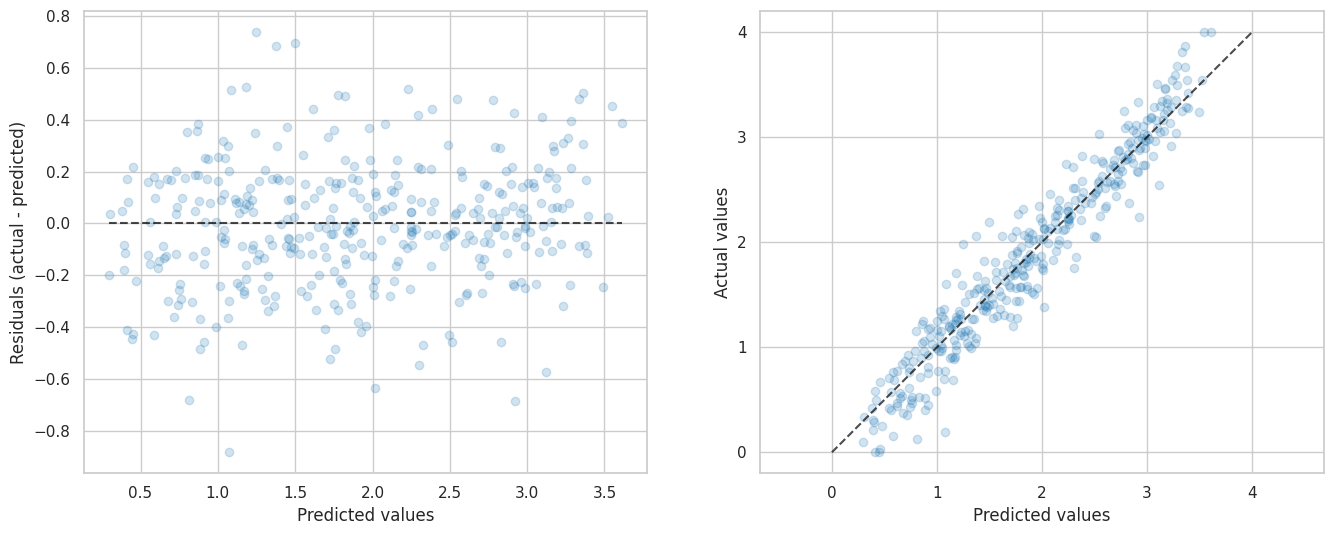

In [702]:
cv_evaluate_model(best_rf, X_train, y_train, 'Random Forest')
rf_results = evaluate_model(best_rf, X_test, y_test, 'Random Forest')

- There is a sign of a slight overfitting: the model performs slightly worse on validation test (> 0.07 RMSE, > 0.05 MAE, < 0.03 R2).
- Model performance on test set is similar to validation set, suggesting the regularization on unknown data.

In [692]:
get_feat_importance(best_rf)

,Feature,Importance
0,num__Absences,0.831146
1,num__StudyTimeWeekly,0.063327
2,ordinal_cat__ParentalSupport,0.031578
3,non_ordinal_cat__Tutoring_1,0.018550
4,ordinal_cat__ParentalEducation,0.008534
5,non_ordinal_cat__Extracurricular_1,0.008278
6,ordinal_cat__Age,0.008202
7,non_ordinal_cat__Music_1,0.007296
8,non_ordinal_cat__Sports_1,0.007073
9,non_ordinal_cat__Gender_1,0.003474


- The (B) feature group still dominate on this model, just alike Linear Regression, indicating that these features are robust.
 

#### Experiment 3: Catboost

In [694]:
# cb_pipe = Pipeline([
#     ("model", cb.CatBoostRegressor(
#         iterations=500, 
#         loss_function='RMSE',
#         random_state=SEED,
#         verbose=0,
#         thread_count=1,
#     ))
# ])

# cb_params = {
#     "model__learning_rate": loguniform(1e-3, 3e-1),
#     "model__depth": randint(4, 10),
#     "model__l2_leaf_reg": loguniform(1e-2, 50),
#     "model__min_data_in_leaf": randint(16, 17),
#     "model__bagging_temperature": loguniform(0.1, 10),
#     "model__rsm": loguniform(0.5, 1.0),
#     "model__bootstrap_type": ["Bayesian", "Bernoulli", "MVS"],
#     "model__grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"],
#     "model__border_count": randint(32, 255)
# }

# random_search = run_random_search(cb_pipe, cb_params)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [695]:
# print(random_search.best_params_)
# best_cb = random_search.best_estimator_
# joblib.dump(best_cb, '../models/best_cb.joblib')

__Output of the above cell__

{'model__bagging_temperature': np.float64(1.9507729462123435), 'model__bootstrap_type': 'MVS', 'model__border_count': 223, 'model__depth': 4, 'model__grow_policy': 'SymmetricTree', 'model__iterations': 186, 'model__l2_leaf_reg': np.float64(1.3056488039139345), 'model__learning_rate': np.float64(0.08013117005374264), 'model__min_data_in_leaf': 17, 'model__rsm': np.float64(0.996229826940137)}

['../models/best_cb.joblib']

In [538]:
best_cb = joblib.load('../models/best_cb.joblib')

5-Fold CV results CatBoost:
            count      mean       std       min       25%       50%       75%  \
rmse_train    5.0  0.170339  0.001612  0.168090  0.169902  0.170157  0.171065   
rmse_val      5.0  0.199620  0.007743  0.188012  0.197294  0.200305  0.203849   
mae_train     5.0  0.136309  0.001448  0.134164  0.135902  0.136199  0.137444   
mae_val       5.0  0.160477  0.006136  0.152391  0.156196  0.162212  0.163874   
r2_train      5.0  0.965318  0.001100  0.964024  0.964974  0.965075  0.965478   
r2_val        5.0  0.951920  0.006178  0.942401  0.951028  0.953071  0.953629   

                 max  
rmse_train  0.172480  
rmse_val    0.208638  
mae_train   0.137834  
mae_val     0.167714  
r2_train    0.967038  
r2_val      0.959472  
Train RMSE: 0.1703 ± 0.0016
Val RMSE: 0.1996 ± 0.0077
Train R²: 0.9653
Val R²: 0.9519

--- CatBoost Regression metrics on test set ---
MAE: 0.1607
RMSE: 0.2031
R2: 0.9507
ME: 0.9051
PSI: 0.0098


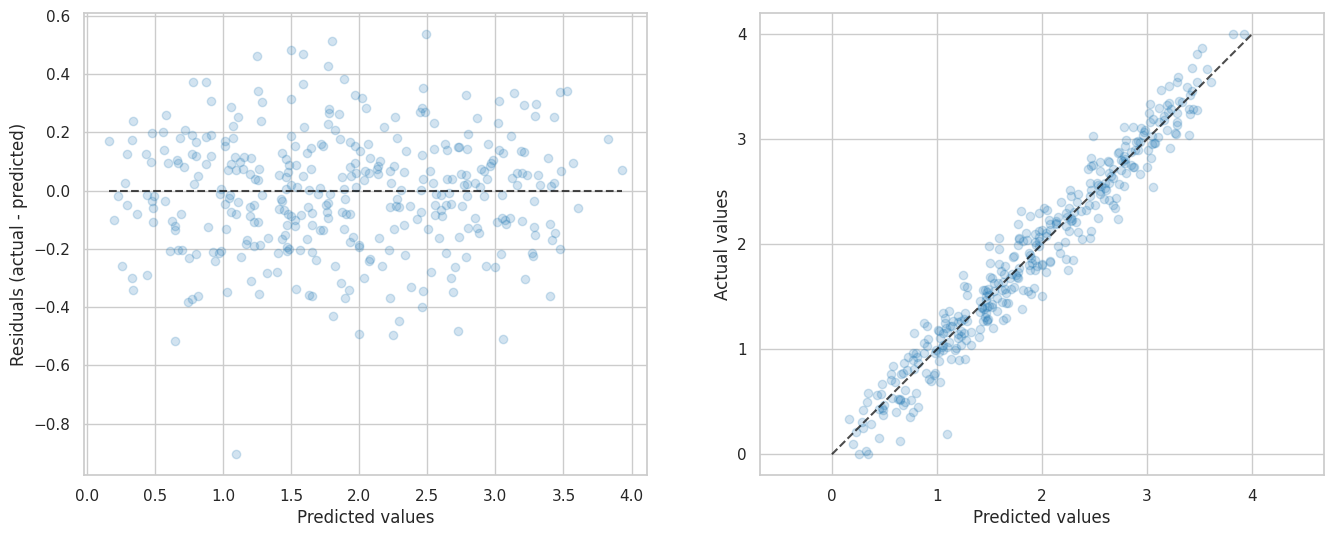

In [703]:
cv_evaluate_model(best_cb, X_train, y_train, 'CatBoost')
cb_results = evaluate_model(best_cb, X_test, y_test, 'CatBoost Regression')

- There's no potensial sign of overfitting, the model performance was good showing no sign of underfitting. As predicted in pre-modeling, CatBoost Regression solves the overfitting pretty well in comparison with Random Forest Regressor.
- Model performance in Validation set is quite similar to Test set, suggesting the regularization on unknown data.

In [540]:
get_feat_importance(best_cb)

,Feature,Importance
0,Absences,76.427815
1,StudyTimeWeekly,6.735317
2,ParentalSupport,6.037651
3,Tutoring,3.761655
4,Extracurricular,2.073146
5,Sports,1.745538
6,Music,1.276406
7,ParentalEducation,0.582244
8,Age,0.517018
9,Ethnicity,0.500180


Catboost Regression also shows the same feature importance to Random Forest model. (They're both tree-based models, CatBoost is better at solving category features.)

#### Experiment 4: Weighted-Voting Ensemble - 1

In [557]:
estimators_1 = [
    ('lr', lr_pipe[-1]),
    ('rf', best_rf[-1]),
    ('cb', best_cb[-1])
]

w_vote_params_3 = {
    "model__weights": [
        (w1, w2, w3)
        for w1 in np.linspace(0.1, 1.0, 10)
        for w2 in np.linspace(0.1, 1.0, 10)
        for w3 in np.linspace(0.1, 1.0, 10)
    ]
}

v_pipe_1 = Pipeline([
    ('prep', preproc_linear),
    ('model', ensemble.VotingRegressor(estimators=estimators_1, n_jobs=3))
])
v_pipe_1

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('ordinal_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# random_search = run_random_search(v_pipe_1, w_vote_params_3)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# best_w_vote_1 = random_search.best_estimator_
# print(random_search.best_params_)
# joblib.dump(best_w_vote_1, '../models/best_w_vote_1.joblib')

{'model__weights': (np.float64(1.0), np.float64(0.1), np.float64(0.2))}


['../models/best_w_vote_1.joblib']

__Output of the above cell__

{'weights': (np.float64(1.0), np.float64(0.1), np.float64(0.3))}

['../models/best_w_vote_1.joblib']


Weighted-voting model seems prefer Linear Regression model to the other (which is still the best model so far so good) by grading the importance of its prediction 100%. The next one is Catboost model (30%) and Random Forest model (10%).

In [696]:
best_w_vote_1 = joblib.load('../models/best_w_vote_1.joblib')

5-Fold CV results Weighted-Voting - 1:
            count      mean       std       min       25%       50%       75%  \
rmse_train    5.0  0.182711  0.002200  0.180225  0.181950  0.182199  0.182969   
rmse_val      5.0  0.197167  0.009842  0.181031  0.195956  0.200081  0.201832   
mae_train     5.0  0.147935  0.001876  0.145826  0.147160  0.147366  0.148491   
mae_val       5.0  0.159691  0.008067  0.147172  0.156628  0.162452  0.164625   
r2_train      5.0  0.960093  0.001451  0.958067  0.959830  0.959957  0.960506   
r2_val        5.0  0.953036  0.006809  0.943338  0.951689  0.953733  0.953995   

                 max  
rmse_train  0.186215  
rmse_val    0.206934  
mae_train   0.150832  
mae_val     0.167580  
r2_train    0.962108  
r2_val      0.962426  
Train RMSE: 0.1827 ± 0.0022
Val RMSE: 0.1972 ± 0.0098
Train R²: 0.9601
Val R²: 0.9530

--- Weighted Voting - 1 metrics on test set ---
MAE: 0.1555
RMSE: 0.1978
R2: 0.9532
ME: 0.8871
PSI: 0.0117


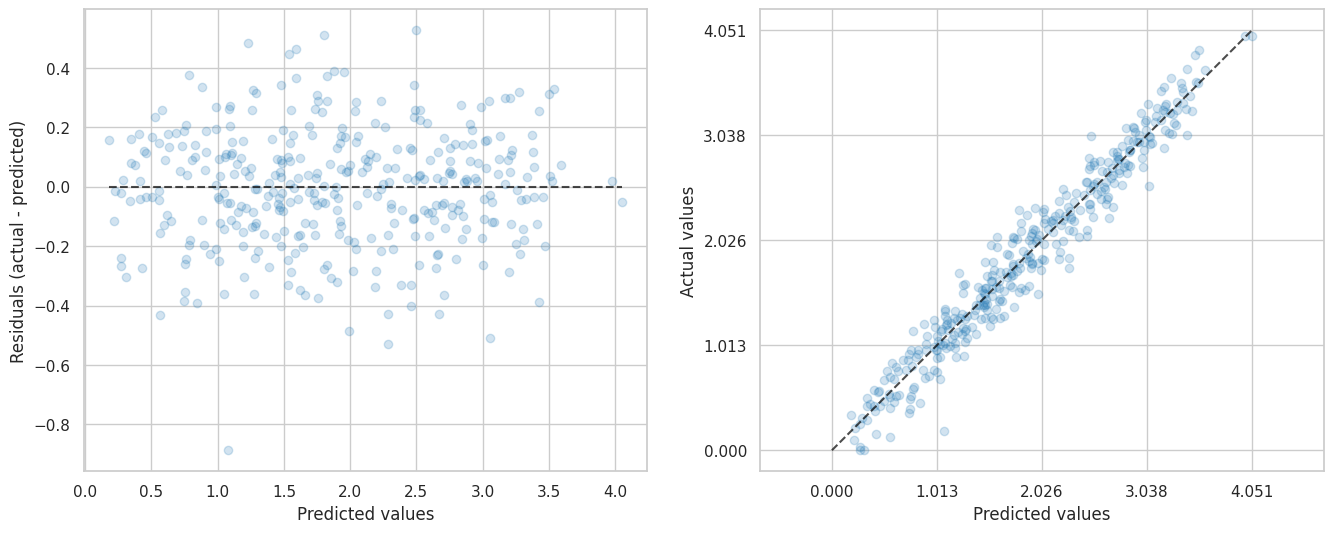

In [704]:
cv_evaluate_model(best_w_vote_1, X_train, y_train, 'Weighted-Voting - 1')
w_vote_results_1 = evaluate_model(best_w_vote_1, X_test, y_test, 'Weighted Voting - 1')

- There is no potential overfitting in this model, all the metrics are quite similar in CV. 

--> This weighted-voting model highly prefer Linear Regression (which stands out so far so good) to the other. Therfore, this is basically the Linear Regression model but much more complicated.

#### Experiment 5: Weighted-Votingl Ensemble - 2

In [570]:
estimators_2 = [
    ('rf', best_rf),
    ('cb', best_cb)
]

w_vote_params_2 = {
    "model__weights": [
        (w1, w2)
        for w1 in np.linspace(0.1, 1.0, 10)
        for w2 in np.linspace(0.1, 1.0, 10)
    ]
}

v_pipe_2 = Pipeline([
    ('model', ensemble.VotingRegressor(estimators=estimators_2, n_jobs=1))
])

In [ ]:
# random_search = RandomizedSearchCV(
#     v_pipe_2, w_vote_params_2, n_iter=50, n_jobs=-1, cv=5
# )
# with tqdm_joblib(tqdm(desc='RandomizedSearch', total=250)) as progress:
#     random_search.fit(X_train, y_train)

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
# best_w_vote_2 = random_search.best_estimator_
# print(random_search.best_params_)
# joblib.dump(best_w_vote_2, '../models/best_w_vote_2.joblib')

{'weights': (np.float64(0.1), np.float64(1.0))}


['../models/best_w_vote_2.joblib']

__Output of the above cell__

{'weights': (np.float64(0.1), np.float64(0.9))}
['../models/best_w_vote_2.joblib'] 


- This voting combination has the same pattern to the first one: The Random Forest model still be evaluated as unimportant model prediction. The CatBoost was highly evaluated at this one.

In [549]:
best_w_vote_2 = joblib.load('../models/best_w_vote_2.joblib')

5-Fold CV results Weighted-Voting - 2:
            count      mean       std       min       25%       50%       75%  \
rmse_train    5.0  0.182711  0.002200  0.180225  0.181950  0.182199  0.182969   
rmse_val      5.0  0.197167  0.009842  0.181031  0.195956  0.200081  0.201832   
mae_train     5.0  0.147935  0.001876  0.145826  0.147160  0.147366  0.148491   
mae_val       5.0  0.159691  0.008067  0.147172  0.156628  0.162452  0.164625   
r2_train      5.0  0.960093  0.001451  0.958067  0.959830  0.959957  0.960506   
r2_val        5.0  0.953036  0.006809  0.943338  0.951689  0.953733  0.953995   

                 max  
rmse_train  0.186215  
rmse_val    0.206934  
mae_train   0.150832  
mae_val     0.167580  
r2_train    0.962108  
r2_val      0.962426  
Train RMSE: 0.1827 ± 0.0022
Val RMSE: 0.1972 ± 0.0098
Train R²: 0.9601
Val R²: 0.9530

--- Weighted Voting - 2 metrics on test set ---
MAE: 0.1615
RMSE: 0.2046
R2: 0.9500
ME: 0.9166
PSI: 0.0123


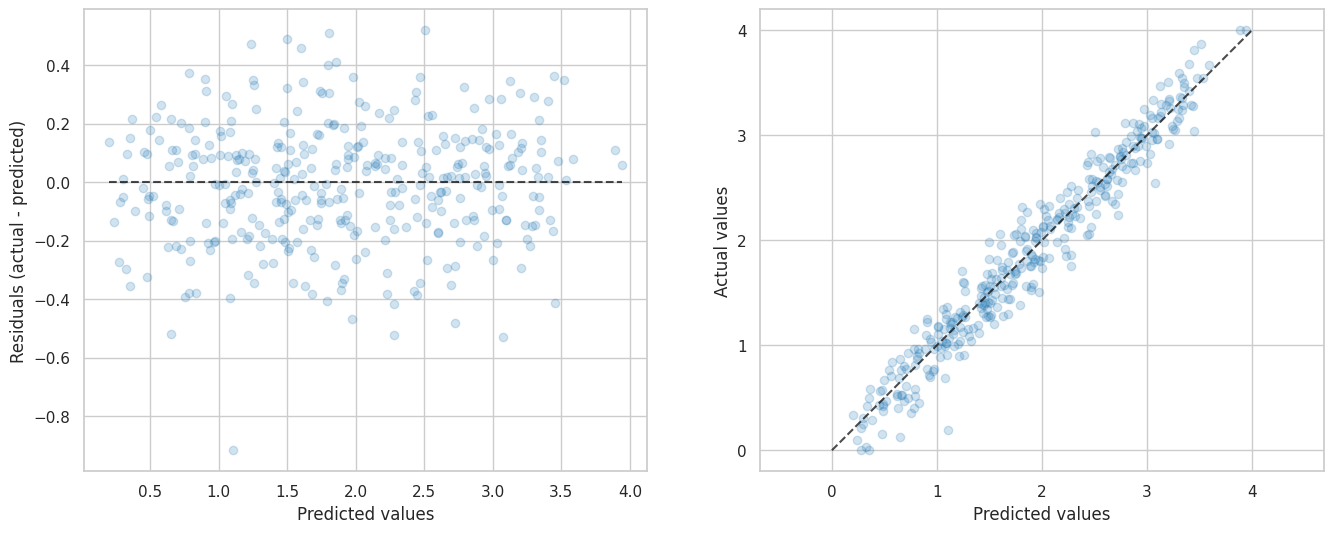

In [705]:
cv_evaluate_model(best_w_vote_1, X_train, y_train, 'Weighted-Voting - 2')
w_vote_results_2 = evaluate_model(best_w_vote_2, X_test, y_test, 'Weighted Voting - 2')

Though model has no potential signs of overfitting and quite generalization (valid performance ~ test performance), the fact that the highly valued of CatBoost Regressor shows that this is basically similar to the result of CatBoost solely.

#### Compare all Models

In [707]:
results = [lr_results, rf_results, cb_results, w_vote_results_1, w_vote_results_2]
results_df = pd.DataFrame(results).set_index('model_name').sort_values(by='mae', ascending=False)
results_df

,mae,rmse,r2,max_error,psi
model_name,,,,,
Random Forest,0.188238,0.242245,0.929856,0.882754,0.014846
Weighted Voting - 2,0.161505,0.204575,0.949975,0.916594,0.012317
CatBoost Regression,0.160660,0.203062,0.950712,0.905115,0.009803
Weighted Voting - 1,0.155500,0.197817,0.953226,0.887098,0.011668
Linear Regression,0.154438,0.196427,0.953881,0.885611,0.011349


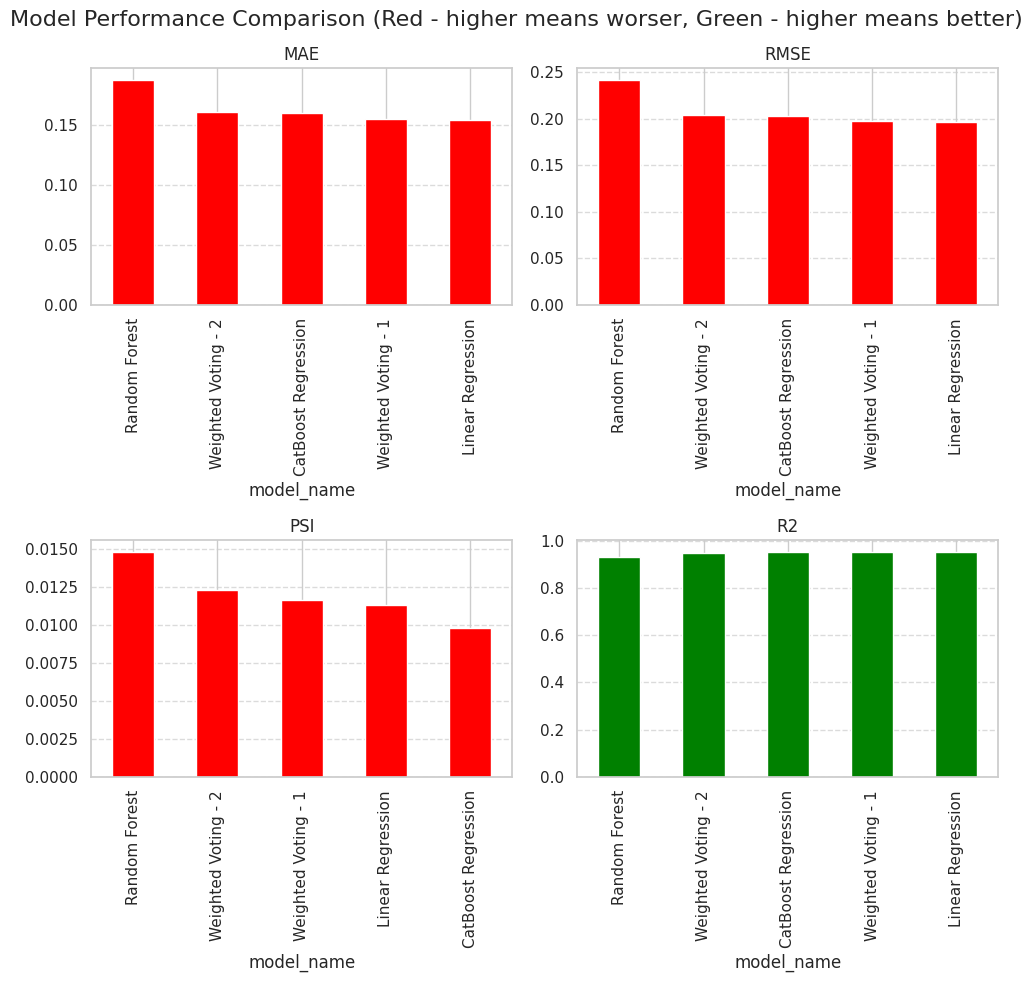

The closer to the right, the better model performance


In [713]:
metrics_to_plot = ['mae', 'rmse', 'psi', 'r2']
colors =          ['red', 'red', 'red', 'green']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(len(metrics_to_plot)):
    m = metrics_to_plot[i]
    c = colors[i]
    yes_ascending = True if colors[i] == 'green' else False
    series = results_df[m].sort_values(ascending=yes_ascending)
    series.plot(kind='bar', ax=axes[i], title=m.upper(), color=c) 
    axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)
plt.suptitle("Model Performance Comparison (Red - higher means worser, Green - higher means better)", fontsize=16)
plt.tight_layout()
plt.show()
print('The closer to the right, the better model performance')

Linear Regression is the best model at 3/4 metrics (MAE, RMSE (our primary), R2) but not the best one in PSI, but LR's PSI metric is still in good threshold so it's okay. 

In [714]:
winner = results_df.sort_values('mae').iloc[0]
winner

mae          0.154438
rmse         0.196427
r2           0.953881
max_error    0.885611
psi          0.011349
Name: Linear Regression, dtype: float64

In [717]:
final_model = lr_pipe

In [718]:
joblib.dump(final_model, '../models/final_model.joblib')

['../models/final_model.joblib']

This is just the final glance to check how bad it can be when it is used for classification because the Max Error metric is pretty high for all models.

In [ ]:
y_pred = final_model.predict(X_test)
y_true_class = [gpa_to_grade(g) for g in y_test]
y_pred_class = [gpa_to_grade(g) for g in y_pred]

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true_class, y_pred_class))

[[  6   5   0   0   0]
 [  0  32   5   1   0]
 [  0   7  43   4   0]
 [  0   0   9  34  16]
 [  0   0   0  10 187]]


There are 1 student with B class are mispredicted over 2 rank (D class) on test set.